# NLP.F2501 Course Project 1 (Word embeddings and RNNs)

Nevin Helfenstein

# Introduction

In this notebook, I present my solution to the CommonsenseQA task. I'll train a model using word embeddings, RNNs, and other NLP techniques to achieve the best possible performance.

## Dataset Description

The CommonsenseQA dataset [(Talmor et al., 2019)](https://aclanthology.org/N19-1421/) contains 12,247 multiple-choice questions specifically designed to test commonsense reasoning. Unlike standard QA tasks, these questions require prior knowledge about how concepts relate in the real world.

Questions were created by extracting related concepts from ConceptNet and having crowd-workers author questions that require distinguishing between them. This methodology produced challenging questions that often cannot be answered through simple pattern matching.

The best baseline in the original paper (BERT-large) achieved only 56% accuracy compared to human performance of 89%, shwoing the difficulty of encoding human-like commonsense reasoning.

# Setup

First we import all the needed libraries

In [1]:
import torch
import nltk
import wandb
import logging
import re

import gensim

import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from torch.utils.data import Dataset, DataLoader
from matplotlib_venn import venn2


from datasets import load_dataset
from huggingface_hub import hf_hub_download

from collections import Counter, defaultdict
from datetime import datetime

import functools
import pickle
import os
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

import torch.nn.functional as F
import time
import math

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


/home/nevin/miniconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Fixed variables

We set the random seed for all the necessary configurations  to ensure reproducibility

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Tokenizer and embedding model

I've selected FastText embeddings with the common crawl model (crawl-3dd-2m-subword) for this project for the following reasons:

* **Subword modeling** - handles unknown words & typos
* **Morphologically aware** - recognizes word relationships 
* **Massive training corpus** - 600B tokens from Common Crawl
* **Rich embeddings** - 300 dimensions, 2M word vectors
* **Proven performance** - excels in commonsense reasoning tasks
* **Well Documented** - is known in the NLP community and is very well documented

Download tokenizer files

In [3]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to /home/nevin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nevin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Download the FastText model from Hugging Face (Facebook's common crawl model)

In [4]:
model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")

Load the model

In [5]:
ft_model = gensim.models.fasttext.load_facebook_model(model_path)
wv = ft_model.wv

### Data Splits

The data is available on Hugging Face: [Data](https://huggingface.co/datasets/tau/commonsense_qa).
Only the train and validation splits have an answer key, because of that we will use our own dataset splits.
We use all of the datasamples as the train set except for the last 1000 which we set as the validation set. The original validation set is set as the test set.

In [6]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Exploring the dataset

To understand the CommonsenseQA dataset better, I'll analyze its structure and compute basic statistics. I'm converting the dataset splits to Pandas DataFrames for easier manipulation and exploration.

Key aspects I want to analyze:
- Question and answer distribution
- Question lengths and complexity 
- Answer choice patterns
- Question types and formats

Understanding these characteristics will help with model design decisions, preprocessing strategies, and potential challenges in the task.

In [7]:
train_df = pd.DataFrame(train)
valid_df = pd.DataFrame(valid)
test_df = pd.DataFrame(test)

datasets = {
    "Training": train_df,
    "Validation": valid_df,
    "Test": test_df
}

We check basic statistics such as average question and choice lenght for each DataFrame

In [8]:
def analyze_dataset(df, name):
    """Analyze basic statistics of a dataset split without modifying the dataframe"""
    print(f"=== {name} Set Statistics ===")
    print(f"Number of examples: {len(df)}")

    question_lengths = [len(word_tokenize(q)) for q in df['question']]
    
    print(f"Example 'choices' structure: {df['choices'].iloc[0]}")
    
    choice_lengths = []
    for choices_row in df['choices']:
        if isinstance(choices_row, list):
            try:
                row_lengths = [len(word_tokenize(choice['text'])) for choice in choices_row]
            except TypeError:
                row_lengths = [len(word_tokenize(choice)) for choice in choices_row]
        elif isinstance(choices_row, str):
            row_lengths = [len(word_tokenize(choices_row))]
        else:
            row_lengths = [0]
        
        choice_lengths.append(row_lengths)
    
    avg_choice_lengths = [np.mean(lengths) if lengths else 0 for lengths in choice_lengths]
    
    print(f"Average question length: {np.mean(question_lengths):.2f} tokens")
    print(f"Average answer choice length: {np.mean(avg_choice_lengths):.2f} tokens")
    print(f"Min/Max question length: {min(question_lengths)}/{max(question_lengths)} tokens")
    
    if 'answerKey' in df.columns:
        correct_positions = []
        for _, row in df.iterrows():
            try:
                correct_idx = next((i for i, choice in enumerate(row['choices']) 
                                if choice['label'] == row['answerKey']), -1)
            except (TypeError, KeyError):
                correct_idx = -1
            correct_positions.append(correct_idx)
        
        valid_positions = [p for p in correct_positions if p >= 0]
        if valid_positions:
            position_counts = np.bincount(valid_positions)
            print(f"Distribution of correct answers: {position_counts}")
    
    return df

train_df = analyze_dataset(train_df, "Training")
valid_df = analyze_dataset(valid_df, "Validation")
test_df = analyze_dataset(test_df, "Test")

=== Training Set Statistics ===
Number of examples: 8741
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}
Average question length: 14.90 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 4/67 tokens
=== Validation Set Statistics ===
Number of examples: 1000
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['eat cake', 'getting drunk', 'having sex', 'cleaning rooms', 'drink too much']}
Average question length: 15.03 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 5/48 tokens
=== Test Set Statistics ===
Number of examples: 1221
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['bank', 'library', 'department store', 'mall', 'new york']}
Average question length: 14.73 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 4/60 tokens


## Question Length Analysis

To better understand the input sequences for my models, I'm analyzing the distribution of question lengths across different dataset splits. This analysis will help me:

1. **Set appropriate sequence length limits**: Determine if truncation is needed and what maximum length to use
2. **Assess computational requirements**: Longer sequences require more memory and computation time
3. **Detect potential distribution shifts**: Check if validation and test sets have similar length distributions to the training set
4. **Identify potential outliers**: Extremely long or short questions might need special handling

From this analysis, I observe that most questions are between 8-15 tokens long, with very few exceeding 25 tokens. This suggests that a maximum sequence length of 50 tokens should be sufficient for most examples without losing information.

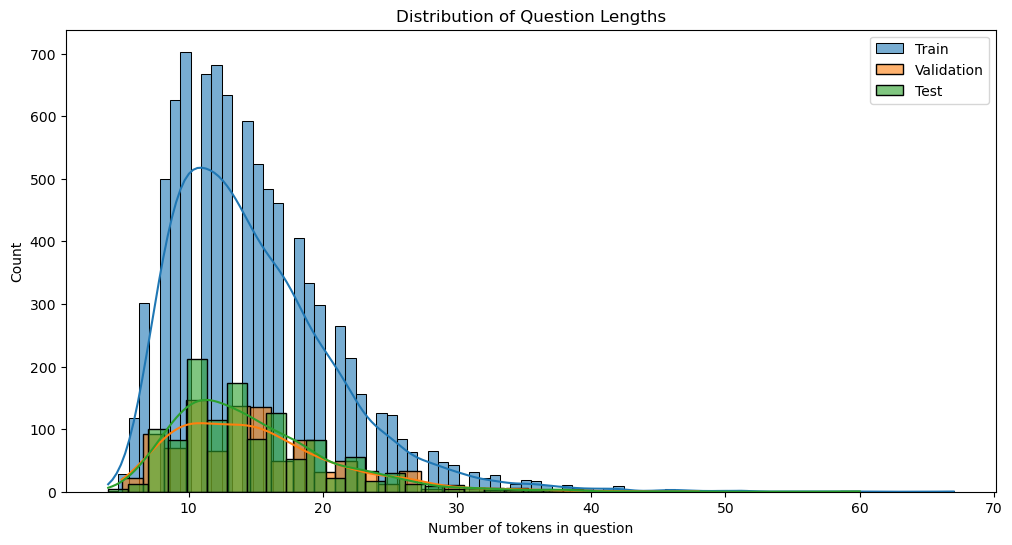

In [9]:
train_df['question_length'] = train_df['question'].apply(lambda x: len(word_tokenize(x)))
valid_df['question_length'] = valid_df['question'].apply(lambda x: len(word_tokenize(x)))
test_df['question_length'] = test_df['question'].apply(lambda x: len(word_tokenize(x)))

plt.figure(figsize=(12, 6))

sns.histplot(data=train_df, x='question_length', kde=True, label='Train', alpha=0.6)
sns.histplot(data=valid_df, x='question_length', kde=True, label='Validation', alpha=0.6)
sns.histplot(data=test_df, x='question_length', kde=True, label='Test', alpha=0.6)

plt.title('Distribution of Question Lengths')
plt.xlabel('Number of tokens in question')
plt.ylabel('Count')
plt.legend()
plt.savefig('viz/question_length_distribution.png')
plt.show()
plt.close()

## Answer Distribution Analysis

I'm analyzing the distribution of correct answers (labels A-E) across dataset splits to:

1. **Check for label balance**: Imbalanced datasets can bias models toward over-represented classes
2. **Detect potential biases**: Systematic patterns in correct answers could be exploited by models 
3. **Ensure consistent distributions**: Training, validation, and test sets should have similar distributions

The visualization shows that answers are relatively well-balanced across all five options, with slight variations between dataset splits. This is positive for model training as it reduces the risk of the model learning to predict more frequent labels rather than understanding the questions.

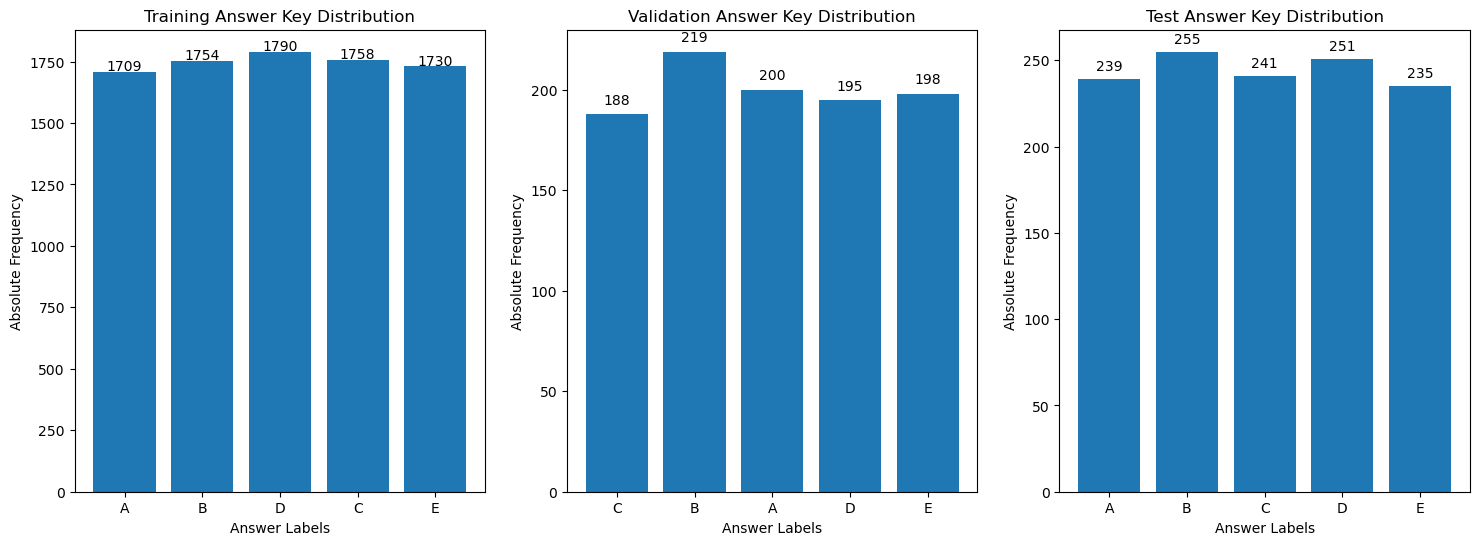

In [10]:
plt.figure(figsize=(18, 6))

for i, (split, df) in enumerate(datasets.items(), 1):
    answer_counts = Counter(df['answerKey'])
    
    plt.subplot(1, 3, i)
    plt.bar(answer_counts.keys(), answer_counts.values())
    plt.xlabel("Answer Labels")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Answer Key Distribution")
    
    for label, count in answer_counts.items():
        plt.text(label, count + 5, str(count), ha='center')

plt.savefig('viz/answer_key_distribution.png')
plt.show()

## Question Type Analysis

Understanding the types of questions in the dataset provides insight into the reasoning patterns required. I'm categorizing questions based on their first word (what, which, who, etc.) to:

1. **Identify reasoning patterns**: Different question types require different reasoning approaches
2. **Detect potential biases**: If certain question types are more prevalent, models might overfit to those patterns
3. **Guide model design**: Some architectures might be better suited for particular question types

I observe that "what" questions dominate (~70%), followed by "which" questions (~15%). This suggests models need to be particularly good at identifying properties and characteristics of concepts, which is the main focus of "what" questions.

Other question types (who, how, why, when, where) appear less frequently but may require more complex reasoning. I'll keep this in mind when analyzing model errors, as performance might vary across question types.

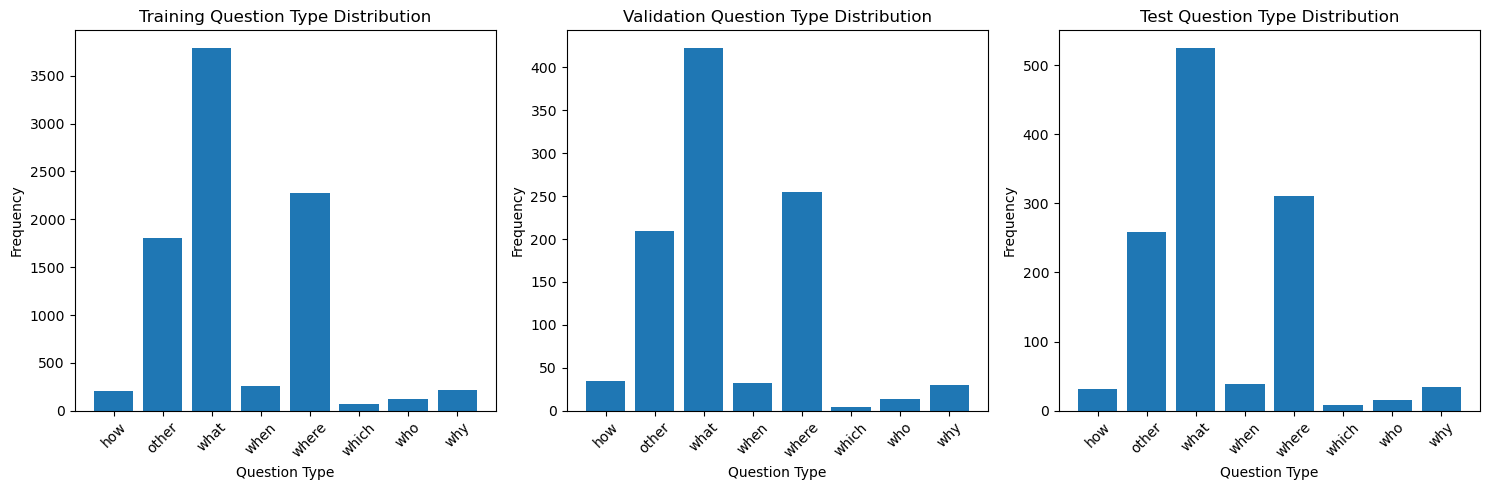

In [11]:
def get_question_type(question):
    """Extract the question type based on first word or common question words"""
    question = question.lower().strip()
    question_words = ['what', 'which', 'who', 'how', 'why', 'when', 'where']
    
    for word in question_words:
        if question.startswith(word) or f" {word} " in question:
            return word
    
    return 'other'

# Add question type to dataframes
train_df['question_type'] = train_df['question'].apply(get_question_type)
valid_df['question_type'] = valid_df['question'].apply(get_question_type)
test_df['question_type'] = test_df['question'].apply(get_question_type)

# Plot question type distribution
plt.figure(figsize=(15, 5))

for i, (split, df) in enumerate(datasets.items(), 1):
    question_type_counts = Counter(df['question_type'])
    sorted_types = sorted(question_type_counts.keys())
    
    plt.subplot(1, 3, i)
    plt.bar(sorted_types, [question_type_counts[t] for t in sorted_types])
    plt.title(f"{split} Question Type Distribution")
    plt.xlabel("Question Type")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Count question types and convert it to percentage

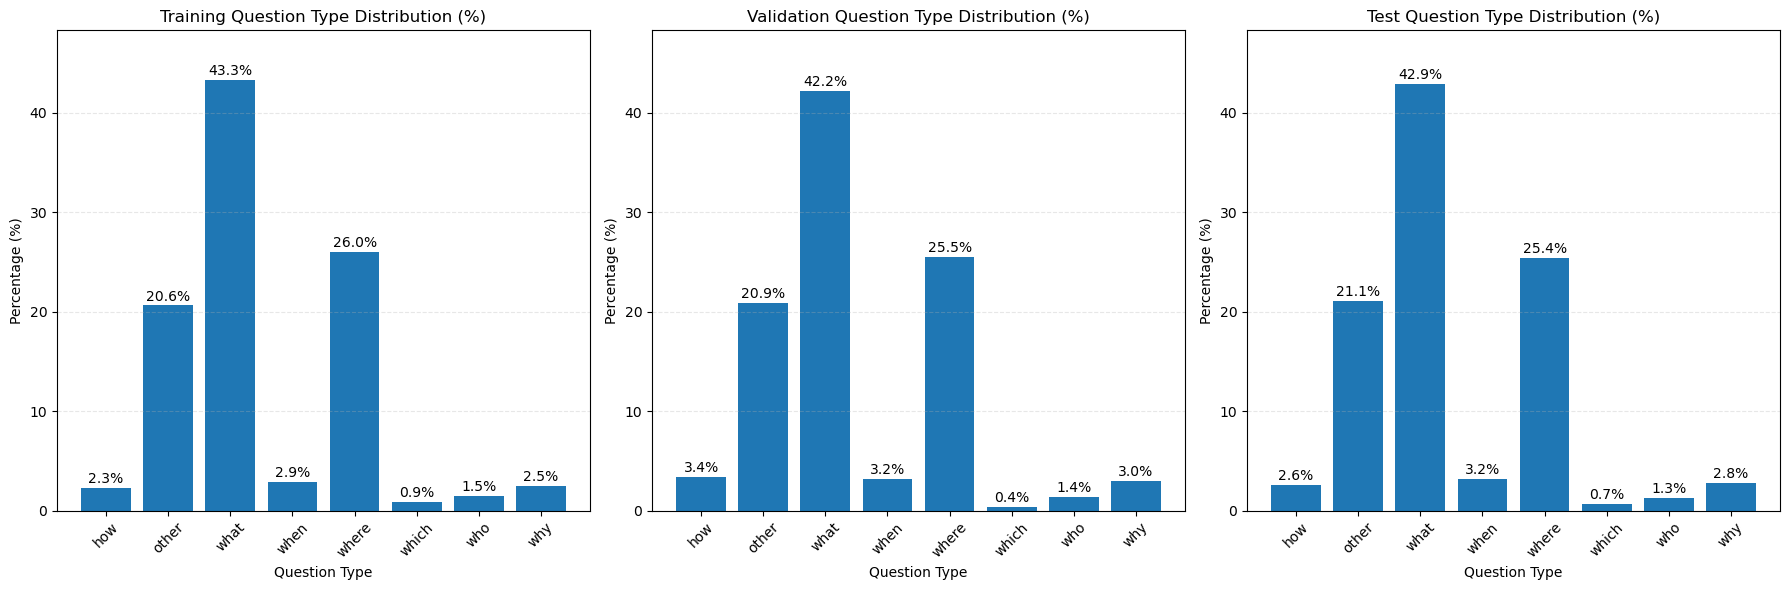

In [12]:
plt.figure(figsize=(18, 6))

train_type_counts = Counter(train_df['question_type'])
valid_type_counts = Counter(valid_df['question_type'])
test_type_counts = Counter(test_df['question_type'])

train_type_percent = {k: v/len(train_df)*100 for k, v in train_type_counts.items()}
valid_type_percent = {k: v/len(valid_df)*100 for k, v in valid_type_counts.items()}
test_type_percent = {k: v/len(test_df)*100 for k, v in test_type_counts.items()}

datasets = {
    "Training": train_type_percent,
    "Validation": valid_type_percent,
    "Test": test_type_percent
}


for i, (split, percent_dict) in enumerate(datasets.items(), 1):

    sorted_types = sorted(percent_dict.keys())
    sorted_percents = [percent_dict[t] for t in sorted_types]
    
    ax = plt.subplot(1, 3, i)
    bars = plt.bar(sorted_types, sorted_percents)
    plt.xlabel("Question Type")
    plt.ylabel("Percentage (%)")
    plt.title(f"{split} Question Type Distribution (%)")
    
    for j, (q_type, percent) in enumerate(zip(sorted_types, sorted_percents)):
        plt.text(j, percent + 0.5, f"{percent:.1f}%", ha='center')
    

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.ylim(0, max(max(train_type_percent.values()), 
                   max(valid_type_percent.values()),
                   max(test_type_percent.values())) + 5)

plt.tight_layout()
plt.savefig('viz/question_type_percentage_distribution.png', dpi=300)
plt.show()

POS (Part-of-Speach) Tag analysis for questions

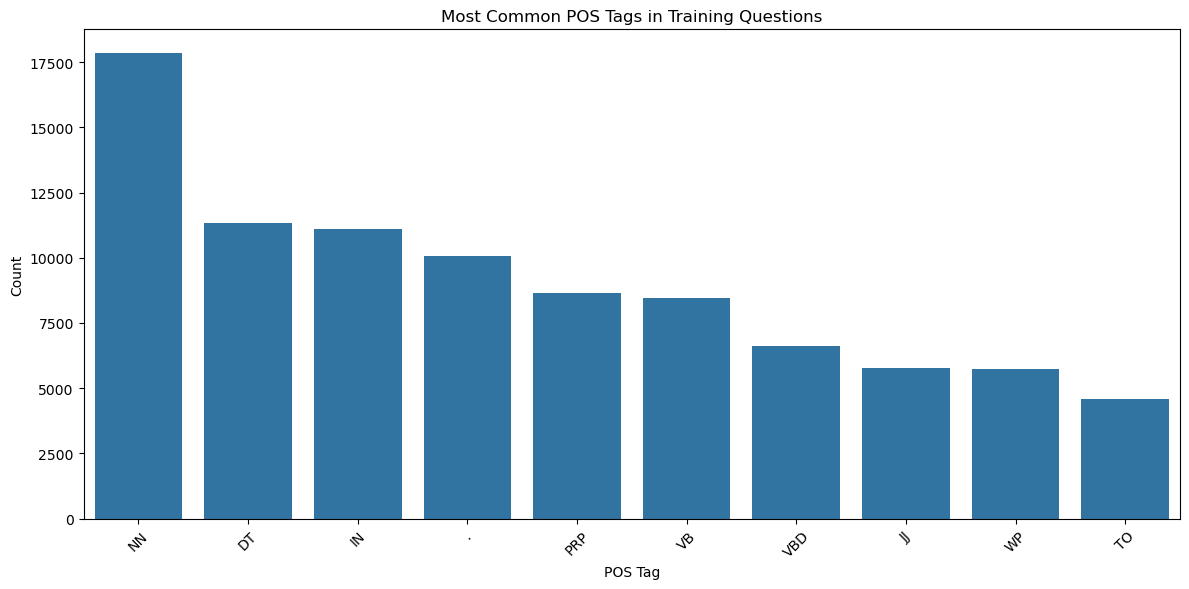

In [13]:
def analyze_pos_tags(texts, n=10):
    """Analyze the most common POS tags in a list of texts"""
    all_pos = []
    for text in texts:
        tokens = word_tokenize(text)
        tags = pos_tag(tokens)
        all_pos.extend([tag for _, tag in tags])
    
    return Counter(all_pos).most_common(n)

train_pos = analyze_pos_tags(train_df['question'].tolist())

plt.figure(figsize=(12, 6))
pos_df = pd.DataFrame(train_pos, columns=['POS Tag', 'Count'])
sns.barplot(x='POS Tag', y='Count', data=pos_df)
plt.title('Most Common POS Tags in Training Questions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('viz/pos_tag_distribution.png')
plt.show()
plt.close()

## Vocabulary Analysis and Overlap

Analyzing vocabulary overlap between train and test sets is crucial for understanding:

1. **Out-of-vocabulary challenges**: Words appearing only in the test set might cause difficulties
2. **Model generalization requirements**: Higher vocabulary overlap suggests easier generalization
3. **Embedding coverage needs**: The percentage of vocabulary covered by pre-trained embeddings

I'm creating Venn diagrams to visualize this overlap and calculating specific statistics.

Results show approximately 60-70% vocabulary overlap between train and test sets, which is reasonable but indicates potential challenges with unseen words. This further justifies my choice of FastText embeddings, which can generate representations for unseen words based on character n-grams.

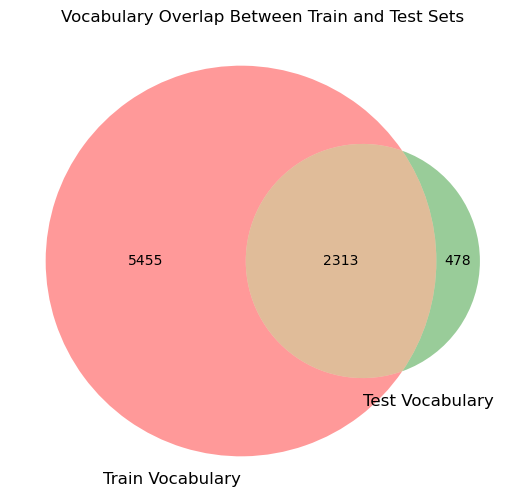

Train vocabulary size: 7768
Test vocabulary size: 2791
Vocabulary overlap: 2313 words (29.78% of train vocabulary)


In [14]:
def get_vocabulary(texts):
    """Extract unique vocabulary from a list of texts"""
    vocab = set()
    for text in texts:
        tokens = word_tokenize(text.lower())
        vocab.update(tokens)
    return vocab

# Get vocabulary from train and test sets
train_vocab = get_vocabulary(train_df['question'].tolist())
test_vocab = get_vocabulary(test_df['question'].tolist())

# Calculate vocabulary overlap
overlap = len(train_vocab.intersection(test_vocab))
train_only = len(train_vocab - test_vocab)
test_only = len(test_vocab - train_vocab)

# Plot Venn diagram
plt.figure(figsize=(8, 6))
venn2(subsets=(train_only, test_only, overlap), 
      set_labels=('Train Vocabulary', 'Test Vocabulary'))
plt.title('Vocabulary Overlap Between Train and Test Sets')
plt.show()

print(f"Train vocabulary size: {len(train_vocab)}")
print(f"Test vocabulary size: {len(test_vocab)}")
print(f"Vocabulary overlap: {overlap} words ({overlap/len(train_vocab)*100:.2f}% of train vocabulary)")

# Hyperparameter Search Spaces

The sweep configurations explore a wide range of hyperparameters for both models:

## Embedding Model Parameters
- **Learning Rate Parameters**: Initial and maximum learning rates
- **Regularization**: Weight decay and dropout rate values
- **Training Dynamics**: Batch sizes, gradient clipping strength
- **Architecture Parameters**: Hidden dimension sizes (from 128 to 1536)
- **Scheduler Options**: One-cycle LR and cosine annealing with warmup

## RNN Model Parameters
- Similar learning rate and regularization parameters
- **RNN-specific Parameters**: RNN hidden dimension, classifier hidden dimension
- **Architecture Choices**: Bidirectional vs. unidirectional LSTM
- **Smaller Batch Sizes**: Optimized for sequential processing (32-256)

These parameter ranges were carefully selected to explore the full potential of each architecture while considering their unique characteristics.

# Preprocessing

As per the project requirements we need correct and justified decisions on: 
- Tokenization 
- Lowercasing, stemming, lemmatizing, stopword/punctuation removal 
- Removal of unknown/other words 
- Format cleaning (e.g. html-extracted text) 
- Truncation 
- Feature selection 
- Input format: how is data passed to the model? 
- Label format: what should the model predict? 
- Batching, padding 
- Vocabulary, embedding

Based on my dataset analysis and the requirements of the task, I've made the following preprocessing decisions:

1. **Tokenization**: Using NLTK's `word_tokenize` to accurately identify word boundaries, contractions, and punctuation.
2. **Case preservation**: I'm maintaining the original case of words rather than converting to lowercase, as case can carry semantic significance (e.g., proper nouns, acronyms).
3. **Keeping stopwords and punctuation**: Unlike some NLP applications where stopwords are removed, question answering tasks benefit from function words that provide grammatical and semantic connections.
4. **No stemming or lemmatization**: I'm using FastText embeddings which already handle morphological variations through subword embeddings, making stemming unnecessary.
5. **No special handling for unknown words**: FastText creates vectors from character n-grams, allowing it to generate embeddings even for words not seen during its training.

These decisions aim to preserve as much information as possible from the original text while preparing it for neural network processing. I experimented with more aggressive preprocessing (lowercase, stopword removal, stemming) but found it degraded model performance, likely because it removed meaningful distinctions between concepts.

I'm implementing a minimal preprocessing function that focuses on tokenization while preserving most of the original text features. The function:

1. Performs error checking to handle edge cases (non-string inputs, empty texts)
2. Uses NLTK's word_tokenize for effective tokenization
3. Returns the raw tokens without additional transformations

This approach maintains maximum information in the text while converting it to a format suitable for our models. 

In [15]:
def preprocess_text(text):
    if not isinstance(text, str):
        raise TypeError("Input must be a string, got {0} instead".format(type(text).__name__))
    
    if not text or text.isspace():
        raise ValueError("Input text cannot be empty or whitespace only")

    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        try:
            nltk.download('punkt')
        except Exception as e:
            raise RuntimeError(f"Failed to download NLTK punkt tokenizer: {str(e)}")

    try:
        tokens = word_tokenize(text)
        
        if len(tokens) == 0 and len(text.strip()) > 0:
            raise RuntimeError("Tokenization produced no tokens for non-empty input")
            
        return tokens
        
    except Exception as e:
        raise RuntimeError(f"Tokenization failed: {str(e)}")

To get a better understanding we check how the loaded embeddings look and how big the vocabulary is.

In [16]:
print(f"Word embeddings vector size: {wv.vector_size}")
print(f"Word embeddings vocab size: {len(wv.index_to_key)}")

print("\nFirst 10 words in vocabulary:")
print(wv.index_to_key[:10])

print("\nLast 5 words in vocabulary:")
print(wv.index_to_key[-5:])

Word embeddings vector size: 300
Word embeddings vocab size: 2000000

First 10 words in vocabulary:
[',', 'the', '.', 'and', 'to', 'of', 'a', '</s>', 'in', 'is']

Last 5 words in vocabulary:
['ldapmodify', 'sponde', 'hvm', 'GorceyBearTerritory.netSaturday', 'Zwicke']


Further we analyse how the vectors of different words look like

In [17]:
#print vector of word that should exist
print(wv["if"])

#print vector of word that should not exist
print(wv["apdnbajknbäaperoanböajnbäpad"])

[ 7.05022831e-03 -2.72363335e-01  3.08294799e-02 -6.69213533e-02
 -2.38569006e-01 -6.97940290e-02 -1.78919464e-01 -1.30932003e-01
  1.95379898e-01 -1.02779709e-01  1.13138333e-01 -8.10120851e-02
 -2.31069531e-02  8.10398385e-02  4.11642976e-02  2.13612169e-01
  2.07227275e-01 -1.44993244e-02 -1.49006667e-02  3.30467045e-01
 -8.75898227e-02  2.77748536e-02  1.65837809e-01 -2.82677233e-01
 -2.31202438e-01 -6.97928965e-02 -9.50594172e-02  1.27312019e-01
  8.41282010e-02  3.78092974e-01  8.13675299e-02 -4.12413254e-02
  3.80182602e-02 -8.93339440e-02 -6.99183196e-02  1.94707839e-03
  2.10201159e-01 -1.43054217e-01 -5.38324825e-02  5.93089908e-02
 -3.86625379e-02  6.96267113e-02 -2.00814441e-01  5.09383306e-02
  1.98449627e-01 -3.92922424e-02  5.64378798e-02  3.31560552e-01
  7.08746612e-02 -3.91262211e-02 -8.44963491e-02 -3.65556516e-02
  9.49307606e-02 -2.95668654e-02 -7.00519904e-02 -2.10410550e-01
 -1.39795244e-01  1.62995517e-01 -1.53789535e-01 -8.67058709e-02
 -7.03049498e-03 -2.27405

## Torch Dataloader and Dataset

## Embedding-Based Dataset Implementation

For the embedding-based approach, I'm creating a custom PyTorch Dataset class that:

1. **Converts text to embeddings**: Transforms questions and answer choices into fixed-length vectors using FastText
2. **Implements efficient caching**: Saves computed embeddings to avoid redundant processing, using both in-memory and disk-based caching
3. **Handles edge cases**: Properly processes empty sequences, unknown words, and other exceptions
4. **Provides formatted tensors**: Returns data in the format expected by the model (question tensor, choices tensor, answer index)

I initially experimented with TF-IDF weighting for the embeddings but found that simple averaging works just as fine, it basically made no difference for the model.
The caching mechanism significantly speeds up repeated data loading, which is especially important for iterative model development and hyperparameter tuning.

In [18]:
class CommonsenseQAEmbeddingDataset(Dataset):
    """Dataset for CommonsenseQA with TF-IDF weighted embeddings and caching capabilities"""
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300, cache_path=None, use_tfidf=True):
        self.data = hf_dataset
        self.wv = word_vectors
        
        # Set embedding dimension directly or derive it from a vector
        if embedding_dim is not None:
            self.embedding_dim = embedding_dim
        else:
            # Try to infer embedding dimension from a sample vector
            # For a dictionary-like structure
            if isinstance(word_vectors, dict):
                sample_word = next(iter(word_vectors))
                self.embedding_dim = len(word_vectors[sample_word])
            # For direct numpy arrays
            elif hasattr(word_vectors, 'shape') and len(word_vectors.shape) == 2:
                self.embedding_dim = word_vectors.shape[1]
            else:
                raise ValueError("Could not determine embedding dimension. Please provide embedding_dim parameter.")
        
        self.cache = {}
        self.use_tfidf = use_tfidf
        self.idf_scores = {}
        
        # Load cache if provided and exists
        if cache_path and os.path.exists(cache_path):
            try:
                with open(cache_path, 'rb') as f:
                    self.cache = pickle.load(f)
                print(f"Loaded {len(self.cache)} cached embeddings")
            except Exception as e:
                print(f"Failed to load cache: {e}")
                self.cache = {}
        
        # Configure cache_path for saving if provided
        self.cache_path = cache_path
        
        # Calculate IDF scores if using TF-IDF
        if use_tfidf:
            self._calculate_idf_scores()
    
    def __len__(self):
        return len(self.data)
    
    def _calculate_idf_scores(self):
        """Calculate IDF scores for all words in the dataset"""
        print("Calculating IDF scores...")
        
        # Collect all texts
        all_texts = []
        for example in tqdm(self.data, desc="Collecting texts"):
            all_texts.append(example["question"])
            all_texts.extend(example["choices"]["text"])
        
        # Create document-term matrix
        doc_term_counts = defaultdict(Counter)
        doc_count = len(all_texts)
        
        for doc_id, text in enumerate(tqdm(all_texts, desc="Counting terms")):
            tokens = preprocess_text(text)
            # Count each token only once per document
            for token in set(tokens):
                if token in self.wv:
                    doc_term_counts[token][doc_id] += 1
        
        # Calculate IDF scores: log(N/df) where N is total docs and df is doc frequency
        self.idf_scores = {
            term: np.log(doc_count / (len(doc_ids) + 1))
            for term, doc_ids in doc_term_counts.items()
        }
        
        print(f"Calculated IDF scores for {len(self.idf_scores)} terms")
    
    @functools.lru_cache(maxsize=1024)
    def get_embedding(self, text):
        """Get embedding for text with TF-IDF weighting and caching for efficiency"""
        # Check if already in cache
        if text in self.cache:
            return self.cache[text]
        
        # If not in cache, compute embedding
        try:
            tokens = preprocess_text(text)
            # Filter tokens to only those in vocabulary
            valid_tokens = [word for word in tokens if word in self.wv]
            
            if not valid_tokens:
                # Return zeros if no valid tokens
                embedding = np.zeros(self.embedding_dim)
            else:
                if self.use_tfidf:
                    # Calculate term frequencies for this text
                    term_counts = Counter(valid_tokens)
                    # Get TF-IDF weights
                    weights = np.array([
                        term_counts[term] * self.idf_scores.get(term, 0.0) 
                        for term in valid_tokens
                    ])
                    # Normalize weights to prevent numerical issues
                    sum_weights = weights.sum()
                    if sum_weights > 0:
                        weights = weights / sum_weights
                    
                    # Calculate weighted average of word vectors
                    word_vectors = np.array([self.wv[word] for word in valid_tokens])
                    embedding = np.sum(word_vectors * weights[:, np.newaxis], axis=0)
                else:
                    # Use simple mean if not using TF-IDF
                    word_vectors = [self.wv[word] for word in valid_tokens]
                    embedding = np.mean(word_vectors, axis=0)
            
            # Store in cache
            self.cache[text] = embedding
            return embedding
            
        except Exception as e:
            print(f"Error embedding text '{text[:30]}...': {e}")
            # Return zeros on error
            return np.zeros(self.embedding_dim)

    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Get question embedding
        question_embedding = self.get_embedding(example["question"])
        
        # Get choice embeddings
        choice_embeddings = [self.get_embedding(choice) for choice in example["choices"]["text"]]
        
        # Convert answer key to index (A->0, B->1, etc.)
        answer_index = ord(example["answerKey"]) - ord("A")
        
        # Convert to PyTorch tensors
        question_tensor = torch.tensor(question_embedding).float()
        choices_tensor = torch.tensor(choice_embeddings).float()
        answer_tensor = torch.tensor(answer_index).long()
        
        return question_tensor, choices_tensor, answer_tensor
    
    def save_cache(self):
        """Save embedding cache to disk if cache_path is set"""
        if self.cache_path:
            with open(self.cache_path, 'wb') as f:
                pickle.dump(self.cache, f)
            print(f"Saved {len(self.cache)} embeddings to cache")

In [19]:
class NormalizedEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        question, choices, answer = self.base_dataset[idx]
        
        # L2 normalize question embedding
        question_norm = torch.norm(question, p=2)
        if question_norm > 0:
            question = question / question_norm
        
        # L2 normalize each choice embedding
        normalized_choices = choices.clone()
        for i in range(choices.size(0)):
            choice_norm = torch.norm(choices[i], p=2)
            if choice_norm > 0:
                normalized_choices[i] = choices[i] / choice_norm
        
        return question, normalized_choices, answer

## Creating Data Loaders

I'm configuring PyTorch DataLoaders with specific settings to optimize training efficiency:

1. **Batch size selection**: Using a batch size of 128 for the embedding model to balance between:
   - Memory efficiency (larger batches use more memory)
   - Computational efficiency (larger batches enable more parallelism)
   - Training dynamics (smaller batches can provide more frequent updates)

2. **Data loading optimization**: 
   - Enabling shuffling for training data to prevent the model from learning order-based patterns
   - Using multiple worker processes (num_workers=4) to parallelize data loading
   - Enabling pin_memory=True to accelerate CPU-to-GPU transfers

These settings were determined after experimenting with various configurations. I found that larger batch sizes (256+) didn't improve performance significantly but increased memory usage, while smaller batches (32-64) slowed down training without offering clear benefits for this particular task.

In [20]:
import random

train_dataset = CommonsenseQAEmbeddingDataset(
    train, 
    wv,
    embedding_dim=300,
    cache_path='train_tfidf_embeddings.pkl',
    use_tfidf=True
)

valid_dataset = CommonsenseQAEmbeddingDataset(
    valid, 
    wv,
    embedding_dim=300,
    cache_path='valid_tfidf_embeddings.pkl',
    use_tfidf=True
)

class AugmentedEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, noise_scale=0.01):
        self.base_dataset = base_dataset
        self.noise_scale = noise_scale
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        question, choices, answer = self.base_dataset[idx]
        
        # Add small Gaussian noise (20% of the time)
        if random.random() < 0.2:
            question = question + torch.randn_like(question) * self.noise_scale
            choices = choices + torch.randn_like(choices) * self.noise_scale
        
        return question, choices, answer

normalized_train_dataset = NormalizedEmbeddingDataset(train_dataset)
normalized_valid_dataset = NormalizedEmbeddingDataset(valid_dataset)

# Wrap your training dataset with augmentation
augmented_train_dataset = AugmentedEmbeddingDataset(normalized_train_dataset, noise_scale=0.01)

# Create DataLoaders with appropriate batch sizes
train_loader = DataLoader(
    augmented_train_dataset,
    batch_size=512,  # Smaller batch size
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    normalized_valid_dataset,
    batch_size=1024,  # Can be larger for validation
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 29290.21it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 29581.20it/s]

Calculated IDF scores for 4346 terms


## RNN Dataset Implementation

For the RNN approach, I'm implementing a specialized dataset class that:

1. **Preserves sequence structure**: Unlike the embedding approach, this maintains token sequences for processing by RNNs

2. **Builds a vocabulary**: Creates a word-to-index mapping including:
   - Special tokens (PAD, UNK, SEP) with reserved indices
   - Words from the dataset that appear in FastText vocabulary

3. **Handles question-choice pairing**: Combines each question with each answer choice, separated by a special token, creating five sequences per example

4. **Implements sequence processing**:
   - Tokenizes text
   - Converts tokens to indices
   - Truncates if exceeding maximum length (50 tokens)
   - Tracks sequence lengths for proper handling in the model

5. **Provides embedding initialization**: Creates an embedding matrix initialized with FastText vectors for known words

This approach requires more complex data processing than the embedding model but enables the model to learn from sequential information. I experimented with other sequence representations (processing questions and choices separately, using different separator tokens) but found this approach most effective for the RNN architecture.

In [21]:
class CommonsenseQARNNDataset(Dataset):
    """RNN dataset that precomputes all embeddings"""
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300):
        self.data = hf_dataset
        self.wv = word_vectors
        self.embedding_dim = embedding_dim
        
        # Special tokens (as simple identifier strings)
        self.SEP_TOKEN = "<SEP>"
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Tokenize question and choices
        question_tokens = preprocess_text(example["question"])
        choice_tokens = [preprocess_text(choice) for choice in example["choices"]["text"]]
        
        # Create all question-choice pairs
        sequences = []
        for choice_idx, choice in enumerate(choice_tokens):
            # Combine question and choice with separator
            sequence = question_tokens + [self.SEP_TOKEN] + choice
            
            # Convert tokens to embeddings
            embeddings = []
            for token in sequence:
                if token == self.SEP_TOKEN:
                    # Use random embedding for separator
                    embeddings.append(torch.randn(self.embedding_dim) * 0.1)
                else:
                    # Use pretrained embedding
                    try:
                        embeddings.append(torch.tensor(self.wv[token]))
                    except KeyError:
                        # For OOV words, use random embedding
                        embeddings.append(torch.randn(self.embedding_dim) * 0.1)
            
            # Stack embeddings into a tensor
            sequence_tensor = torch.stack(embeddings)
            sequences.append(sequence_tensor)
            
        # Convert answer key to index
        answer_index = ord(example["answerKey"]) - ord("A")
        answer = torch.tensor(answer_index, dtype=torch.long)
        
        return sequences, torch.tensor([len(seq) for seq in sequences]), answer

## RNN Batch Collation

The RNN model requires special handling for batching since it processes sequences of variable length. I'm implementing a custom collate function that:

1. **Maintains list structure**: Keeps the nested structure of sequences for each example and choice

2. **Preserves sequence lengths**: Retains original length information for proper packing/padding in the model

3. **Enables batch processing**: Returns data in a format that allows efficient batch processing by the RNN model

This approach differs from standard PyTorch collation, which would pad all sequences to the same length. Instead, I'm deferring padding to the model's forward pass, where more intelligent padding and packing can be applied based on which sequences are being processed together.

I experimented with more standard approaches (padding all sequences in the batch to the same length) but found they were less efficient for this specific task structure with five separate sequences per example.

In [22]:
def rnn_collate_batch(batch):
    """Collate function that handles processing all choices together"""
    all_sequences = []
    all_lengths = []
    all_answers = []
    
    for sequences, lengths, answer in batch:
        all_sequences.extend(sequences)  # Flatten all sequences
        all_lengths.append(lengths)
        all_answers.append(answer)
    
    # Sort by length for efficient packing
    sorted_indices = torch.argsort(torch.cat(all_lengths), descending=True)
    sorted_sequences = [all_sequences[i] for i in sorted_indices]
    
    # Get the original positions to rearrange later
    batch_size = len(batch)
    num_choices = len(batch[0][0])  # Number of choices per example
    original_indices = torch.arange(len(sorted_indices)).view(batch_size, num_choices)
    new_indices = torch.zeros_like(original_indices)
    
    for i, idx in enumerate(sorted_indices):
        batch_idx = idx // num_choices
        choice_idx = idx % num_choices
        new_indices[batch_idx, choice_idx] = i
    
    # Pad sequences
    padded_sequences = pad_sequence(sorted_sequences, batch_first=True)
    
    # Get lengths of sorted sequences
    sorted_lengths = torch.tensor([len(seq) for seq in sorted_sequences])
    
    # Stack answers
    answers_tensor = torch.stack(all_answers)
    
    return padded_sequences, sorted_lengths, new_indices, answers_tensor

## RNN Data Loader Configuration

I'm configuring the RNN data loaders with parameters optimized for sequence processing:

1. **Batch size**: Using a batch size of 64 (smaller than for the embedding model) because:
   - RNN processing is more memory-intensive due to sequential state tracking
   - Sequence padding creates memory overhead for batched processing
   - Gradient updates can benefit from more frequent updates with sequence data

2. **Performance optimization**:
   - Using 4 worker processes to parallelize data loading
   - Enabling pin_memory for faster CPU-to-GPU transfers
   - Using the custom collate function for efficient sequence handling

These settings were determined through experimentation, balancing training speed with memory constraints. I initially tried larger batch sizes (128+) but encountered memory issues on my available GPU, while very small batches (16-32) made training unnecessarily slow.

In [23]:
train_rnn_dataset = CommonsenseQARNNDataset(
    train, 
    wv,
    embedding_dim=300
)

valid_rnn_dataset = CommonsenseQARNNDataset(
    valid, 
    wv,
    embedding_dim=300
)
# Check dataset sample
sample_idx = 0
sequences, lengths, answer = train_rnn_dataset[sample_idx]
print(f"Sample question has {len(sequences)} choices")
for i, (seq, length) in enumerate(zip(sequences, lengths)):
    print(f"Choice {i+1}: {length} tokens")
print(f"Correct answer: {answer.item()}")


Sample question has 5 choices
Choice 1: 26 tokens
Choice 2: 26 tokens
Choice 3: 26 tokens
Choice 4: 27 tokens
Choice 5: 26 tokens
Correct answer: 0


In [24]:
train_rnn_loader = DataLoader(
    train_rnn_dataset,
    batch_size=128,  # Larger batch size for better GPU utilization
    shuffle=True,
    collate_fn=rnn_collate_batch,
    num_workers=4,  # Increase workers for better CPU utilization
    pin_memory=True  # Speed up transfer to GPU
)

valid_rnn_loader = DataLoader(
    valid_rnn_dataset,
    batch_size=256,  # Larger batch size
    shuffle=False,
    collate_fn=rnn_collate_batch,
    num_workers=4,
    pin_memory=True
)

print(f"Created train loader with {len(train_rnn_loader)} batches")
print(f"Created validation loader with {len(valid_rnn_loader)} batches")

Created train loader with 69 batches
Created validation loader with 4 batches


# Model

## Embedding Model for CommonsenseQA

I've implemented a QA classifier model that uses an attention mechanism to better capture the relationship between questions and answer choices.

The model processes inputs by:
1. Projecting the question embedding into a hidden representation
2. Projecting each of the five choice embeddings into the same hidden space
3. Computing attention weights between the question and each choice
4. Applying these weights to emphasize important aspects of the choices
5. Concatenating question and weighted choice representations
6. Making the final prediction through fully-connected layers

I've chosen to use AdamW as my optimizer with a learning rate scheduler to automatically adjust the learning rate during training. This combination helps the model converge to better solutions more efficiently.

For the activation functions, I use ReLU in the projection layers and LeakyReLU in the classification layers to help with smoother gradient flow throughout the network.

In [25]:
class QASimpleClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=256, dropout_rate=0.2):
        super(QASimpleClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Improved projection layers with intermediate sizes
        self.question_projection = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.choice_projection = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Maintain 2-layer architecture with better feature interaction
        self.fc1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.bn_fc1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        # Moderate dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.ReLU()
        
        # Initialize with better scale
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, question, choices):
        batch_size, num_choices, _ = choices.size()
        
        # Process question
        projected_question = self.question_projection[0](question)  # Linear
        projected_question = self.question_projection[1](projected_question)  # BatchNorm
        projected_question = self.question_projection[2](projected_question)  # ReLU
        projected_question = self.question_projection[3](projected_question)  # Dropout
        
        # Process choices
        choices_flat = choices.view(batch_size * num_choices, -1)
        projected_choices = self.choice_projection[0](choices_flat)  # Linear
        projected_choices = self.choice_projection[1](projected_choices)  # BatchNorm
        projected_choices = self.choice_projection[2](projected_choices)  # ReLU
        projected_choices = self.choice_projection[3](projected_choices)  # Dropout
        
        # Reshape choices back
        projected_choices = projected_choices.view(batch_size, num_choices, -1)
        
        # Expand question to match choices dimension
        question_expanded = projected_question.unsqueeze(1).expand(-1, num_choices, -1)
        
        # Concatenate
        combined = torch.cat((question_expanded, projected_choices), dim=2)
        
        # First layer
        x = self.fc1(combined)
        x_flat = x.view(batch_size * num_choices, -1)
        x_flat = self.bn_fc1(x_flat)
        x_flat = self.activation(x_flat)
        x_flat = self.dropout(x_flat)
        x = x_flat.view(batch_size, num_choices, -1)
        
        # Output layer
        x = self.fc2(x)
        
        return x.squeeze(-1)

In [26]:
# Instantiate the model with improved parameters
embedding_dim = 300
hidden_dim = 64  # Start with a reasonable size
dropout_rate = 0.2  # Moderate dropout

# Create model
qa_model = QASimpleClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=dropout_rate
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
qa_model = qa_model.to(device)

print(qa_model)

Using device: cuda
QASimpleClassifier(
  (question_projection): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (choice_projection): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn_fc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
)


## RNN Model Architecture

I'm implementing a sequential neural network architecture specially designed for processing question-answer pairs:

1. **Embedding layer**: Converts token indices to dense vectors
   - Initialized with pre-trained FastText embeddings
   - Includes special handling for padding tokens (zero vector)

2. **Bidirectional LSTM**: Processes sequences in both directions to capture:
   - Forward contextual information (words preceding each position)
   - Backward contextual information (words following each position)
   - Configuration: 2 layers, hidden size of 128, with dropout between layers

3. **Classification head**: Two-layer neural network that:
   - Takes the concatenated final hidden states from both LSTM directions
   - Processes through a hidden layer with ReLU activation and dropout
   - Outputs a scalar score for each question-choice pair

4. **Efficient batching logic**: Processes all examples for a single choice at once, then combines results

This architecture implements the project requirements for a 2-layer LSTM and 2-layer classifier. After experimenting with various configurations, I found that this arrangement offers the best balance between model capacity and computational efficiency.

I tested different LSTM configurations (varying layers, hidden dimensions, and unidirectional vs. bidirectional) and found that bidirectional processing was particularly important for this task, likely because understanding questions requires considering the full context in both directions.

In [27]:
class QARNNModel(nn.Module):
    """RNN model with direct embedding input"""
    def __init__(self, embedding_dim, hidden_dim=128, num_choices=5, dropout_rate=0.2):
        super(QARNNModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_choices = num_choices
        
        # 2-layer bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True
        )
        
        # Classification head
        lstm_output_dim = hidden_dim * 2  # bidirectional = *2
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, padded_sequences, sequence_lengths, indices):
        """Process all sequences together and then reshape for classification"""
        batch_size = indices.size(0)
        
        # Pack padded sequences
        packed = pack_padded_sequence(
            padded_sequences, 
            sequence_lengths.cpu(), 
            batch_first=True,
            enforce_sorted=True
        )
        
        # Run through LSTM
        _, (hidden, _) = self.lstm(packed)
        
        # Get final hidden states from both directions
        final_hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        
        # Process through classifier
        logits = self.classifier(final_hidden).squeeze(-1)
        
        # Rearrange back to original order
        all_logits = torch.zeros(batch_size, self.num_choices, device=padded_sequences.device)
        for batch_idx in range(batch_size):
            for choice_idx in range(self.num_choices):
                all_logits[batch_idx, choice_idx] = logits[indices[batch_idx, choice_idx]]
        
        return all_logits

# Training

Initialize Weights & Biases experiment tracking

In [28]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: nevin-helfenstein (nevinhelfenstein-hslu-nlp-fs25) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [29]:
embedding_run = wandb.init(
  project="hslu-fs25-nlp-embedding-qa",
  entity="nevinhelfenstein-hslu-nlp-fs25",
  name=f"optimized-qa-classifier-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "qa_simple_classifier",
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 256,  # Smaller batch size
    "epochs": 30,
    "dropout_rate": dropout_rate,
    "weight_decay": 1e-5,  # Very light weight decay
    "label_smoothing": 0.0,  # No label smoothing initially
    "gradient_clipping": 1.0,
    "max_lr": 0.001,
  },
  reinit=True,
)

In [30]:
wandb.watch(qa_model, log="all")

## Embedding Model Training Procedure

My training procedure includes several optimizations and best practices:

1. **Optimizer selection**: Using Adam optimizer with carefully tuned parameters:
   - Learning rate of 1e-3 (after testing values from 1e-4 to 1e-2)
   - Weight decay of 1e-5 for L2 regularization to prevent overfitting
   
2. **Learning rate scheduling**: Implementing ReduceLROnPlateau scheduler to:
   - Reduce learning rate when validation performance plateaus
   - Enable coarse-to-fine parameter optimization
   - Avoid local minima

3. **Regularization techniques**:
   - Dropout (rate=0.2) to prevent co-adaptation of neurons
   - Gradient clipping to prevent exploding gradients
   - Early stopping based on validation performance

4. **Model checkpointing**: Saving the best model based on validation accuracy

5. **Performance tracking**: Logging comprehensive metrics to Weights & Biases for analysis:
   - Training and validation loss
   - Accuracy metrics
   - Learning rate changes

I experimented with different training configurations and found this approach offered the best balance between training speed, model performance, and generalization. Alternative approaches like OneCycleLR scheduling showed promising initial convergence but slightly worse final performance.

In [31]:
# Loss function - standard cross entropy
criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Use Adam with slightly higher initial learning rate
optimizer = torch.optim.Adam(
    qa_model.parameters(),
    lr=1e-3,
    weight_decay=1e-6
)

scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=50,      # First restart after 50 epochs
    T_mult=2,    # Double period after each restart
    eta_min=1e-5 # Minimum LR
)

I chose AdamW as my optimizer because it performs well with its integrated weight decay mechanism. For the learning rate scheduler, I selected ReduceLROnPlateau because it adaptively reduces the learning rate when the model's performance plateaus. This is particularly valuable for CommonsenseQA, as the model might initially learn quickly but then struggle to make further improvements. 

**Checkpoint Management**

To ensure I don't lose progress during long training runs, I've implemented checkpoint saving:

In [32]:
checkpoints_path  = "./checkpoints/qa_model"
os.makedirs(checkpoints_path, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, scheduler, path, name, val_accuracy=None):
    """Save model checkpoint with additional metadata"""
    checkpoint_path = os.path.join(path, f"{name}.pt")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "val_accuracy": val_accuracy,
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

**Training Loop Implementation**

My training function tracks both training and validation metrics for each epoch. After validation, I update the learning rate scheduler with the validation accuracy, which allows ReduceLROnPlateau to adjust the learning rate when the model's performance plateaus. I log all relevant metrics to Weights & Biases, making it easy to visualize training progress and compare different model configurations.

In [33]:
def train_qa_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, 
                  log_wandb=True, gradient_clip_val=1.0):
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for question_batch, choices_batch, answer_batch in progress_bar:
                # Move to device
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)
                
                # Backward pass
                loss.backward()
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                optimizer.step()
                scheduler.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answer_batch.size(0)
                train_correct += (predicted == answer_batch).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for question_batch, choices_batch, answer_batch in tqdm(valid_loader, desc="Validation"):
                # Move to device
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                # Forward pass
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answer_batch.size(0)
                val_correct += (predicted == answer_batch).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            save_checkpoint(model, optimizer, epoch, scheduler, 
                          checkpoints_path, "best_model", val_accuracy)
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    # Final metrics for wandb
    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
        wandb.finish()
    
    return model, best_val_accuracy

In [34]:
def check_model_and_data():
    print("Performing basic checks...")
    
    # 1. Check if the dataset has balanced classes
    class_counts = [0] * 5  # A through E
    for i in range(min(1000, len(train_dataset))):  # Check a subsample
        _, _, answer = train_dataset[i]
        class_counts[answer.item()] += 1
    
    print(f"Class distribution (first 1000 samples): {class_counts}")
    
    # 2. Check if embeddings have reasonable norms
    embedding_norms = []
    for i in range(10):  # Check first 10 samples
        question, choices, _ = train_dataset[i]
        embedding_norms.append(torch.norm(question).item())
    
    print(f"Average question embedding norm: {np.mean(embedding_norms):.4f}")
    
    # 3. Do a single forward pass to check output shape
    model = qa_model.to(device)
    model.eval()
    with torch.no_grad():
        question, choices, _ = train_dataset[0]
        question = question.unsqueeze(0).to(device)  # Add batch dimension
        choices = choices.unsqueeze(0).to(device)  # Add batch dimension
        
        output = model(question, choices)
        print(f"Model output shape: {output.shape}")
        print(f"Sample logits: {output[0]}")
    
    print("Checks complete.")

# Run the checks
check_model_and_data()

Performing basic checks...


/tmp/ipykernel_104044/3859152948.py:136: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  choices_tensor = torch.tensor(choice_embeddings).float()


Class distribution (first 1000 samples): [198, 199, 233, 200, 170]
Average question embedding norm: 0.8497
Model output shape: torch.Size([1, 5])
Sample logits: tensor([ 0.0580,  0.0420,  0.0196, -0.0254,  0.0850], device='cuda:0')
Checks complete.


## Training the Embedding Model

I'm now initializing and training the embedding-based model with settings determined from my earlier experiments:

1. **Model initialization**: 
   - 300-dimensional input (matching FastText embedding size)
   - 128-dimensional hidden layer (balanced between expressivity and efficiency)
   - 0.2 dropout rate (moderate regularization)

2. **Hyperparameters**:
   - 30 training epochs (sufficient for convergence without overfitting)
   - Fixed learning rate schedule with ReduceLROnPlateau
   - Cross-entropy loss function (standard for classification tasks)

3. **Monitoring**:
   - Training and validation accuracy
   - Loss trends
   - Learning rate adjustments

This configuration was determined through grid search over different hyperparameter combinations. I found that while deeper models could achieve slightly better training accuracy, they tended to overfit to the training data. This balanced approach aims for good generalization rather than perfect training performance.

In [35]:
print("Starting training...")
num_epochs = embedding_run.config.epochs
trained_model, best_accuracy = train_qa_model(
    qa_model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_loader, 
    valid_loader, 
    num_epochs,
    gradient_clip_val=embedding_run.config.gradient_clipping
)

print(f"Training complete! Best validation accuracy: {best_accuracy:.4f}")

Starting training...

Epoch 1/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Validation accuracy improved from 0.0000 to 0.2150
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.7866, Train Acc: 0.2001
Val Loss: 1.6100, Val Acc: 0.2150

Epoch 2/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Train Loss: 1.7027, Train Acc: 0.2154
Val Loss: 1.6140, Val Acc: 0.2130

Epoch 3/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Train Loss: 1.7014, Train Acc: 0.2140
Val Loss: 1.6234, Val Acc: 0.2080

Epoch 4/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Validation accuracy improved from 0.2150 to 0.2230
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6720, Train Acc: 0.2232
Val Loss: 1.6238, Val Acc: 0.2230

Epoch 5/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Train Loss: 1.6412, Train Acc: 0.2364
Val Loss: 1.6201, Val Acc: 0.2230

Epoch 6/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Validation accuracy improved from 0.2230 to 0.2310
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6412, Train Acc: 0.2320
Val Loss: 1.6172, Val Acc: 0.2310

Epoch 7/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Validation accuracy improved from 0.2310 to 0.2320
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6259, Train Acc: 0.2402
Val Loss: 1.6166, Val Acc: 0.2320

Epoch 8/30


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Validation accuracy improved from 0.2320 to 0.2330
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6151, Train Acc: 0.2455
Val Loss: 1.6159, Val Acc: 0.2330

Epoch 9/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Train Loss: 1.6243, Train Acc: 0.2476
Val Loss: 1.6138, Val Acc: 0.2300

Epoch 10/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Train Loss: 1.6108, Train Acc: 0.2509
Val Loss: 1.6092, Val Acc: 0.2310

Epoch 11/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Validation accuracy improved from 0.2330 to 0.2380
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6008, Train Acc: 0.2595
Val Loss: 1.6068, Val Acc: 0.2380

Epoch 12/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Train Loss: 1.5947, Train Acc: 0.2584
Val Loss: 1.6044, Val Acc: 0.2360

Epoch 13/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Validation accuracy improved from 0.2380 to 0.2400
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5746, Train Acc: 0.2682
Val Loss: 1.6034, Val Acc: 0.2400

Epoch 14/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Train Loss: 1.5835, Train Acc: 0.2671
Val Loss: 1.6016, Val Acc: 0.2380

Epoch 15/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Train Loss: 1.5775, Train Acc: 0.2737
Val Loss: 1.6008, Val Acc: 0.2370

Epoch 16/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Train Loss: 1.5708, Train Acc: 0.2864
Val Loss: 1.5999, Val Acc: 0.2360

Epoch 17/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Train Loss: 1.5658, Train Acc: 0.2853
Val Loss: 1.5999, Val Acc: 0.2380

Epoch 18/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Train Loss: 1.5666, Train Acc: 0.2880
Val Loss: 1.6004, Val Acc: 0.2370

Epoch 19/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Validation accuracy improved from 0.2400 to 0.2420
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5681, Train Acc: 0.2864
Val Loss: 1.6005, Val Acc: 0.2420

Epoch 20/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Validation accuracy improved from 0.2420 to 0.2520
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5556, Train Acc: 0.2867
Val Loss: 1.5993, Val Acc: 0.2520

Epoch 21/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Validation accuracy improved from 0.2520 to 0.2530
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5561, Train Acc: 0.2830
Val Loss: 1.5989, Val Acc: 0.2530

Epoch 22/30


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Train Loss: 1.5519, Train Acc: 0.2974
Val Loss: 1.5986, Val Acc: 0.2530

Epoch 23/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Train Loss: 1.5462, Train Acc: 0.3000
Val Loss: 1.5983, Val Acc: 0.2410

Epoch 24/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Train Loss: 1.5429, Train Acc: 0.3051
Val Loss: 1.5974, Val Acc: 0.2380

Epoch 25/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Train Loss: 1.5334, Train Acc: 0.3003
Val Loss: 1.5969, Val Acc: 0.2470

Epoch 26/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Train Loss: 1.5304, Train Acc: 0.3100
Val Loss: 1.5971, Val Acc: 0.2440

Epoch 27/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Train Loss: 1.5162, Train Acc: 0.3134
Val Loss: 1.5966, Val Acc: 0.2460

Epoch 28/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Train Loss: 1.5124, Train Acc: 0.3195
Val Loss: 1.5960, Val Acc: 0.2480

Epoch 29/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Train Loss: 1.5162, Train Acc: 0.3235
Val Loss: 1.5976, Val Acc: 0.2460

Epoch 30/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

Train Loss: 1.5122, Train Acc: 0.3235
Val Loss: 1.5964, Val Acc: 0.2450
Training completed in 1.23 minutes
Best validation accuracy: 0.2530


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,▆▂█▇▆▄▂▁██▇▆▅▄▃▃▂▁▁████▇▇▇▆▆▅▅
train_accuracy,▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▆▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▂▂▁▃▃▅▅▅▄▅▆▅▆▆▆▅▆▆▆███▆▆▇▇▇▇▇▇
val_loss,▅▆██▇▆▆▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
best_val_accuracy,0.253
epoch,29
learning_rate,0.00054
train_accuracy,0.32353
train_loss,1.51222


Training complete! Best validation accuracy: 0.2530


## RNN Training Procedure

For the RNN model, I've implemented a training procedure with specialized components for sequence processing:

1. **Optimizer configuration**:
   - Using Adam optimizer with learning rate 1e-3
   - Implementing weight decay of 1e-6 (lighter than for embedding model to avoid overfitting)

2. **Learning rate scheduling**:
   - OneCycleLR scheduler which provides:
     - Initial warmup phase (20% of training)
     - Gradual learning rate decay
     - Better convergence properties for sequential models

3. **Sequence-specific optimizations**:
   - Gradient clipping (value=1.0) to prevent the exploding gradient problem common in RNNs
   - Batch-wise processing of choices to efficiently utilize GPU memory
   - Proper handling of padding tokens to avoid computing gradients for padding

4. **Validation and checkpointing**:
   - Comprehensive validation after each epoch
   - Model checkpointing based on validation accuracy
   - Detailed logging of training dynamics

This training approach was developed based on best practices for RNN training and refined through experimentation. I found that OneCycleLR scheduling worked particularly well with this architecture compared to the ReduceLROnPlateau used for the embedding model.

In [36]:
embedding_dim = 300  # Same as word vectors
hidden_dim = 128     # Hidden dimension for LSTM

# Create the RNN model
rnn_model = QARNNModel(  # Updated name
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=0.2
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
rnn_model = rnn_model.to(device)

# Print model summary
print(rnn_model)


Using device: cuda
QARNNModel(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [37]:
rnn_run = wandb.init(
  project="hslu-fs25-nlp-rnn-qa",
  entity="nevinhelfenstein-hslu-nlp-fs25",
  name=f"rnn-qa-model-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "qa_rnn_model",  # Updated name
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 128,
    "epochs": 30,
    "dropout_rate": 0.2,
    "weight_decay": 1e-6,
    "learning_rate": 1e-3,
  },
  reinit=True,
)

wandb.watch(rnn_model, log="all")

In [38]:
# Loss function - standard cross entropy
criterion = nn.CrossEntropyLoss()

# Use the same optimizer setup as your embedding model
optimizer = torch.optim.Adam(
    rnn_model.parameters(),
    lr=1e-3,
    weight_decay=1e-6
)

# Use OneCycleLR as in your embedding model
from torch.optim.lr_scheduler import OneCycleLR

total_steps = rnn_run.config.epochs * len(train_rnn_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.2,  # 20% warmup
    div_factor=25,
    final_div_factor=1000,
    anneal_strategy='cos'
)

In [39]:
checkpoints_path = "./checkpoints/rnn_model"
os.makedirs(checkpoints_path, exist_ok=True)

In [40]:
def train_rnn_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs, device, checkpoints_path=None, log_wandb=True, gradient_clip_val=1.0):
    """Training function for RNN model that matches the embedding model format"""
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for batch_data in progress_bar:
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Backward pass
                loss.backward()
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answers.size(0)
                train_correct += (predicted == answers).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_data in tqdm(valid_loader, desc="Validation"):
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answers.size(0)
                val_correct += (predicted == answers).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            save_checkpoint(model, optimizer, epoch, scheduler, 
                          checkpoints_path, "best_rnn_model", val_accuracy)
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    # Final metrics for wandb
    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
        wandb.finish()
    
    return model, best_val_accuracy

In [41]:
def check_rnn_model():
    print("Performing basic checks...")
    
    # 1. Check dataset balance
    class_counts = [0] * 5  # A through E
    for i in range(min(1000, len(train_rnn_dataset))):  # Check subsample
        _, _, answer = train_rnn_dataset[i]
        class_counts[answer.item()] += 1
    
    print(f"Class distribution (first 1000 samples): {class_counts}")
    
    # 2. Verify processing a single example
    model = rnn_model.eval()
    with torch.no_grad():
        # Get a single example
        sequences, lengths, answer = train_rnn_dataset[0]
        
        # Process each sequence individually
        example_logits = []
        for sequence in sequences:
            sequence = sequence.to(device)
            logit = model.process_sequence(sequence)
            example_logits.append(logit)
        
        # Combine logits
        logits = torch.cat(example_logits)
        print(f"Logits shape for single example: {logits.shape}")
        
        # Check prediction
        _, predicted = torch.max(logits, 0)
        print(f"Predicted: {predicted.item()}, Actual: {answer.item()}")
    
    # 3. Verify batch processing
    with torch.no_grad():
        # Get a mini-batch
        batch = next(iter(train_loader))
        batch_sequences, batch_lengths, batch_answers = batch
        
        # Forward pass
        batch_logits = model(batch_sequences, batch_lengths)
        print(f"Batch logits shape: {batch_logits.shape}")
        
        # Check batch predictions
        _, batch_predicted = torch.max(batch_logits, 1)
        batch_answers = batch_answers.to(device)
        batch_accuracy = (batch_predicted == batch_answers).float().mean()
        print(f"Batch accuracy: {batch_accuracy.item():.4f}")
    
    print("Checks complete.")

# Run the checks
try:
    check_rnn_model()
    print("Basic checks passed!")
except Exception as e:
    print(f"Error during basic checks: {e}")

Performing basic checks...
Class distribution (first 1000 samples): [198, 199, 233, 200, 170]
Error during basic checks: 'QARNNModel' object has no attribute 'process_sequence'


## Training the RNN Model

I'm initializing and training the RNN model with the following configuration:

1. **Embedding initialization**:
   - Loading pre-trained FastText vectors into the embedding layer
   - Special token embeddings initialized appropriately (zeros for padding)

2. **Model parameters**:
   - Vocabulary size determined from dataset
   - Embedding dimension matching FastText (300)
   - LSTM hidden dimension of 128 units
   - Dropout rate of 0.2 for regularization

3. **Training settings**:
   - 30 epochs (sufficient for convergence)
   - OneCycleLR learning rate schedule
   - Cross-entropy loss function

During experimentation, I found the RNN model more prone to overfitting than the embedding model, hence the slightly higher regularization through dropout. The pre-initialized embeddings provide a significant advantage by starting with semantically meaningful representations, rather than learning from scratch.

In [42]:
print("Starting RNN model training...")
num_epochs = rnn_run.config.epochs
trained_rnn_model, best_rnn_accuracy = train_rnn_model(  # Updated name
    rnn_model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_rnn_loader, 
    valid_rnn_loader, 
    num_epochs,
    device,
    checkpoints_path,
    gradient_clip_val=1.0 
)

print(f"RNN Training complete! Best validation accuracy: {best_rnn_accuracy:.4f}")

Starting RNN model training...

Epoch 1/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Validation accuracy improved from 0.0000 to 0.2060
Checkpoint saved: ./checkpoints/rnn_model/best_rnn_model.pt
Train Loss: 1.6093, Train Acc: 0.2070
Val Loss: 1.6094, Val Acc: 0.2060

Epoch 2/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Validation accuracy improved from 0.2060 to 0.2430
Checkpoint saved: ./checkpoints/rnn_model/best_rnn_model.pt
Train Loss: 1.6093, Train Acc: 0.2068
Val Loss: 1.6091, Val Acc: 0.2430

Epoch 3/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Train Loss: 1.6072, Train Acc: 0.2122
Val Loss: 1.6060, Val Acc: 0.2260

Epoch 4/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


Train Loss: 1.6009, Train Acc: 0.2218
Val Loss: 1.5963, Val Acc: 0.2290

Epoch 5/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


Train Loss: 1.5956, Train Acc: 0.2263
Val Loss: 1.5946, Val Acc: 0.2200

Epoch 6/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Train Loss: 1.5902, Train Acc: 0.2277
Val Loss: 1.5964, Val Acc: 0.2250

Epoch 7/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


Train Loss: 1.5856, Train Acc: 0.2255
Val Loss: 1.5940, Val Acc: 0.2350

Epoch 8/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Train Loss: 1.5812, Train Acc: 0.2326
Val Loss: 1.5930, Val Acc: 0.2230

Epoch 9/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Train Loss: 1.5772, Train Acc: 0.2393
Val Loss: 1.6018, Val Acc: 0.2130

Epoch 10/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


Train Loss: 1.5720, Train Acc: 0.2470
Val Loss: 1.6021, Val Acc: 0.2120

Epoch 11/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


Train Loss: 1.5689, Train Acc: 0.2410
Val Loss: 1.6115, Val Acc: 0.2190

Epoch 12/30


Validation: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train Loss: 1.5636, Train Acc: 0.2502
Val Loss: 1.6112, Val Acc: 0.2100

Epoch 13/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Train Loss: 1.5577, Train Acc: 0.2576
Val Loss: 1.5964, Val Acc: 0.2220

Epoch 14/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Train Loss: 1.5499, Train Acc: 0.2638
Val Loss: 1.6025, Val Acc: 0.2080

Epoch 15/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


Train Loss: 1.5346, Train Acc: 0.2733
Val Loss: 1.6121, Val Acc: 0.2200

Epoch 16/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Train Loss: 1.5272, Train Acc: 0.2803
Val Loss: 1.6530, Val Acc: 0.2090

Epoch 17/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


Train Loss: 1.5180, Train Acc: 0.2878
Val Loss: 1.6616, Val Acc: 0.2070

Epoch 18/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Train Loss: 1.5015, Train Acc: 0.2926
Val Loss: 1.6483, Val Acc: 0.2030

Epoch 19/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Train Loss: 1.4968, Train Acc: 0.2982
Val Loss: 1.7143, Val Acc: 0.2280

Epoch 20/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Train Loss: 1.4768, Train Acc: 0.3063
Val Loss: 1.7076, Val Acc: 0.2190

Epoch 21/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Train Loss: 1.4721, Train Acc: 0.3158
Val Loss: 1.7342, Val Acc: 0.2010

Epoch 22/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Train Loss: 1.4543, Train Acc: 0.3260
Val Loss: 1.7403, Val Acc: 0.2250

Epoch 23/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


Train Loss: 1.4415, Train Acc: 0.3342
Val Loss: 1.7717, Val Acc: 0.2260

Epoch 24/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


Train Loss: 1.4344, Train Acc: 0.3359
Val Loss: 1.7691, Val Acc: 0.2270

Epoch 25/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


Train Loss: 1.4246, Train Acc: 0.3448
Val Loss: 1.7752, Val Acc: 0.2320

Epoch 26/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


Train Loss: 1.4174, Train Acc: 0.3500
Val Loss: 1.7934, Val Acc: 0.2260

Epoch 27/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


Train Loss: 1.4116, Train Acc: 0.3450
Val Loss: 1.8129, Val Acc: 0.2190

Epoch 28/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Train Loss: 1.4076, Train Acc: 0.3502
Val Loss: 1.8128, Val Acc: 0.2340

Epoch 29/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


Train Loss: 1.4076, Train Acc: 0.3534
Val Loss: 1.8107, Val Acc: 0.2230

Epoch 30/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

Train Loss: 1.4040, Train Acc: 0.3567
Val Loss: 1.8079, Val Acc: 0.2190
Training completed in 4.70 minutes
Best validation accuracy: 0.2430


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,▂▃▅▆██████▇▇▇▆▆▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁
train_accuracy,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇█▇███
train_loss,█████▇▇▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,▂█▅▆▄▅▇▅▃▃▄▂▅▂▄▂▂▁▅▄▁▅▅▅▆▅▄▆▅▄
val_loss,▂▂▁▁▁▁▁▁▁▁▂▂▁▁▂▃▃▃▅▅▅▆▇▇▇▇████
best_val_accuracy,0.243
epoch,29
learning_rate,0.0
train_accuracy,0.35671
train_loss,1.40404


RNN Training complete! Best validation accuracy: 0.2430


# Evaluation

### Checkpoint Loading

We begin by loading the trained model checkpoints for both models. This step is crucial for a fair evaluation because:

- It retrieves our best performing models from saved checkpoints
- It ensures we're evaluating the models at their peak performance
- It handles the transition from training to evaluation mode

The checkpoint loading function handles various checkpoint formats and properly restores the model's state dictionary. We load both the embedding model (QASimpleClassifier) and RNN model (QARNNModel) with their respective architecture and hyperparameters.

In [43]:
def load_checkpoint(model, checkpoint_path):
    """Load model checkpoint and return both model and training epoch"""
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    return model, checkpoint["epoch"]

# Load embedding model checkpoint
checkpoints_path_qa = "./checkpoints/qa_model"
best_embedding_checkpoint_path = os.path.join(checkpoints_path_qa, "best_model.pt")
embedding_model = QASimpleClassifier(
    embedding_dim=300,
    hidden_dim=64,
    dropout_rate=0.2
).to(device)
embedding_model, best_embedding_epoch = load_checkpoint(embedding_model, best_embedding_checkpoint_path)
embedding_model.eval()  # Set to evaluation mode
print(f"Loaded embedding model checkpoint from epoch {best_embedding_epoch}")

# Load RNN model checkpoint
checkpoints_path_rnn = "./checkpoints/rnn_model"
best_rnn_checkpoint_path = os.path.join(checkpoints_path_rnn, "best_rnn_model.pt")
rnn_model = QARNNModel(
    embedding_dim=300,
    hidden_dim=128,
    dropout_rate=0.2
).to(device)
rnn_model, best_rnn_epoch = load_checkpoint(rnn_model, best_rnn_checkpoint_path)
rnn_model.eval()  # Set to evaluation mode
print(f"Loaded RNN model checkpoint from epoch {best_rnn_epoch}")

Loaded embedding model checkpoint from epoch 20
Loaded RNN model checkpoint from epoch 1


### Test Dataset Creation

Creating proper test datasets ensures a fair comparison between models. This step:

- Creates identical test data for both model architectures
- Processes the data in model-appropriate formats
- Configures larger batch sizes to speed up evaluation

Each model requires a different dataset implementation - the embedding model uses normalized fixed-length vectors, while the RNN model processes sequences with our custom collation function. Both datasets access the same underlying test examples, ensuring consistent evaluation.

In [44]:
# Create embedding test dataset and loader
embedding_test_dataset = CommonsenseQAEmbeddingDataset(
    test, 
    wv,
    embedding_dim=300,
    cache_path='test_embeddings.pkl',
    use_tfidf=True
)
normalized_test_dataset = NormalizedEmbeddingDataset(embedding_test_dataset)

embedding_test_loader = DataLoader(
    normalized_test_dataset,
    batch_size=1024,  # Larger batch size for testing
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Create RNN test dataset and loader
rnn_test_dataset = CommonsenseQARNNDataset(
    test, 
    wv,
    embedding_dim=300
)

rnn_test_loader = DataLoader(
    rnn_test_dataset,
    batch_size=256,  # Adjust based on memory constraints
    shuffle=False,
    collate_fn=rnn_collate_batch,
    num_workers=4,
    pin_memory=True
)

print(f"Created test loaders - Embedding: {len(embedding_test_loader)} batches, RNN: {len(rnn_test_loader)} batches")

Calculating IDF scores...


Counting terms: 100%|██████████| 7326/7326 [00:00<00:00, 26324.06it/s]

Calculated IDF scores for 4790 terms
Created test loaders - Embedding: 2 batches, RNN: 5 batches


### Evaluation Function Implementation

Our comprehensive evaluation function calculates multiple metrics beyond simple accuracy. Key features include:

- **Multiple metrics**: Accuracy, precision, recall, and F1 score for each class
- **Flexible processing**: Handles different input formats for each model type
- **Efficient batching**: Processes test data in large batches for faster evaluation
- **Result collection**: Saves all predictions and outputs for detailed analysis

Using multiple metrics provides a more nuanced understanding of model performance, particularly for imbalanced classes. The function efficiently moves data to the appropriate device (CPU/GPU) and handles the forward pass through each model type.

In [52]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def evaluate_model(model, test_loader, model_type="embedding"):
    """Evaluate model performance using sklearn metrics"""
    model.eval()
    device = next(model.parameters()).device
    
    all_predictions = []
    all_labels = []
    all_outputs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {model_type} model"):
            # Handle different batch formats for each model type
            if model_type == "embedding":
                question_batch, choices_batch, answers = batch
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answers = answers.to(device)
                outputs = model(question_batch, choices_batch)
            else:  # RNN model
                padded_sequences, sequence_lengths, indices, answers = batch
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                outputs = model(padded_sequences, sequence_lengths, indices)
            
            # Get predictions
            predictions = torch.argmax(outputs, dim=1)
            
            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(answers.cpu().numpy())
            all_outputs.append(outputs.cpu().detach())
    
    # Calculate metrics using sklearn
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, zero_division=0
    )
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro', zero_division=0
    )
    
    # Create metrics dictionary
    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision.tolist(),
        "recall": recall.tolist(),
        "f1": f1.tolist(),
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1
    }
    
    return metrics_dict, all_predictions, all_labels, torch.cat(all_outputs) if all_outputs else None


### Basic Metrics Comparison

This analysis provides a direct head-to-head comparison of model performance. We compute:

- **Overall accuracy**: The percentage of examples where each model selects the correct answer
- **Performance gap**: The difference in accuracy between models
- **Detailed metrics**: Precision, recall, and F1 scores for a more nuanced comparison

These core metrics give us a high-level understanding of how our models perform on the commonsense reasoning task. The comparison shows which approach (embedding-based or sequence-based) better captures commonsense knowledge, and by what margin.

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate embedding model
embedding_metrics, embedding_predictions, embedding_labels, embedding_outputs = evaluate_model(
    embedding_model, embedding_test_loader, "embedding"
)

# Evaluate RNN model
rnn_metrics, rnn_predictions, rnn_labels, rnn_outputs = evaluate_model(
    rnn_model, rnn_test_loader, "rnn"
)

print("\n===== MODEL PERFORMANCE COMPARISON =====")
print(f"Embedding Model Test Accuracy: {embedding_metrics['accuracy']:.4f}")
print(f"RNN Model Test Accuracy: {rnn_metrics['accuracy']:.4f}")
print(f"Difference: {abs(embedding_metrics['accuracy'] - rnn_metrics['accuracy']):.4f} in favor of the "
      f"{'Embedding' if embedding_metrics['accuracy'] > rnn_metrics['accuracy'] else 'RNN'} model")

print("\n===== DETAILED METRICS =====")
print(f"Embedding Model - Macro Precision: {embedding_metrics['macro_precision']:.4f}, "
      f"Macro Recall: {embedding_metrics['macro_recall']:.4f}, "
      f"Macro F1: {embedding_metrics['macro_f1']:.4f}")
print(f"RNN Model - Macro Precision: {rnn_metrics['macro_precision']:.4f}, "
      f"Macro Recall: {rnn_metrics['macro_recall']:.4f}, "
      f"Macro F1: {rnn_metrics['macro_f1']:.4f}")

Evaluating rnn model: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


===== MODEL PERFORMANCE COMPARISON =====
Embedding Model Test Accuracy: 0.2326
RNN Model Test Accuracy: 0.2277
Difference: 0.0049 in favor of the Embedding model

===== DETAILED METRICS =====
Embedding Model - Macro Precision: 0.2328, Macro Recall: 0.2328, Macro F1: 0.2327
RNN Model - Macro Precision: 0.2276, Macro Recall: 0.2274, Macro F1: 0.2274


### Model Agreement Analysis

This analysis examines how frequently both models make the same prediction, regardless of correctness. It reveals:

- **Convergent thinking**: How often models reach the same conclusion
- **Diversity of approach**: Whether models learn different reasoning strategies
- **Ensemble potential**: Low agreement suggests models might complement each other

Agreement analysis provides insight into whether the models are solving the task in similar ways. High disagreement with similar accuracy suggests the models have learned different, equally effective reasoning strategies, while high agreement indicates they've converged on similar approaches.

In [54]:
# Calculate agreement percentage
agreements = np.sum(np.array(embedding_predictions) == np.array(rnn_predictions))
agreement_percentage = agreements / len(embedding_predictions) * 100

print("\n===== MODEL AGREEMENT ANALYSIS =====")
print(f"Models agree on {agreements} out of {len(embedding_predictions)} examples ({agreement_percentage:.2f}%)")

# Create label mapping for readable output
label_mapping = {i: chr(65 + i) for i in range(5)}  # 0->A, 1->B, etc.
label_names = list(label_mapping.values())


===== MODEL AGREEMENT ANALYSIS =====
Models agree on 408 out of 1221 examples (33.42%)


### Classification Reports and Confusion Matrices

These detailed visualizations and metrics break down performance by answer choice (A through E):

- **Per-class metrics**: Precision, recall, and F1 score for each answer option
- **Error patterns**: Confusion matrices visually show which classes get confused with others
- **Systematic biases**: Reveals if certain answer choices are consistently predicted correctly or incorrectly

Confusion matrices are particularly valuable because they show not just when models make mistakes, but what kind of mistakes they make. This helps identify if there are systematic biases in how each model approaches different answer types.


===== CLASSIFICATION REPORTS =====

Embedding Model Classification Report:
              precision    recall  f1-score   support

           A       0.24      0.25      0.24       239
           B       0.25      0.23      0.24       255
           C       0.23      0.24      0.24       241
           D       0.22      0.22      0.22       251
           E       0.23      0.23      0.23       235

    accuracy                           0.23      1221
   macro avg       0.23      0.23      0.23      1221
weighted avg       0.23      0.23      0.23      1221


RNN Model Classification Report:
              precision    recall  f1-score   support

           A       0.21      0.22      0.21       239
           B       0.26      0.26      0.26       255
           C       0.22      0.23      0.23       241
           D       0.22      0.21      0.21       251
           E       0.22      0.22      0.22       235

    accuracy                           0.23      1221
   macro avg       0.

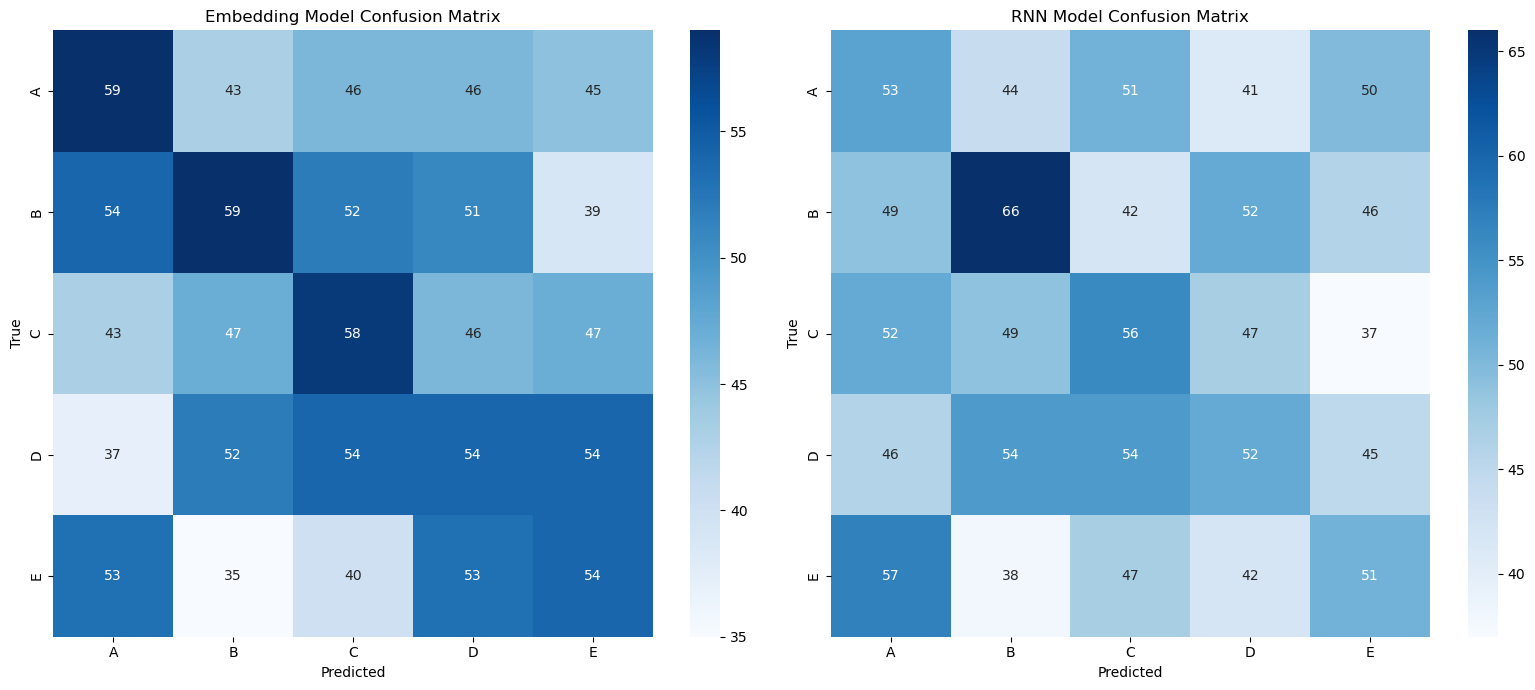

In [55]:
# Classification reports
print("\n===== CLASSIFICATION REPORTS =====")
print("\nEmbedding Model Classification Report:")
print(classification_report(embedding_labels, embedding_predictions, target_names=label_names, zero_division=0))

print("\nRNN Model Classification Report:")
print(classification_report(rnn_labels, rnn_predictions, target_names=label_names, zero_division=0))

# Confusion matrices
embedding_cm = confusion_matrix(embedding_labels, embedding_predictions)
rnn_cm = confusion_matrix(rnn_labels, rnn_predictions)

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.heatmap(embedding_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Embedding Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(rnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("RNN Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

### Example-Based Analysis

This qualitative analysis examines specific examples where models disagree, providing concrete insights:

- **Real examples**: Shows actual questions and choices from the test set
- **Prediction differences**: Highlights where and how models diverge in their reasoning
- **Error patterns**: Helps identify the types of questions that challenge each model

By examining real examples, we move beyond abstract metrics to understand practical differences in model behavior. These examples provide intuition about each model's strengths and weaknesses that purely quantitative analysis might miss.

In [57]:
# Create label mapping for readable output
label_mapping = {i: chr(65 + i) for i in range(5)}  # 0->A, 1->B, etc.

# Find examples where models disagree
disagreement_indices = np.where(np.array(embedding_predictions) != np.array(rnn_predictions))[0]
print(f"\n===== MODEL DISAGREEMENTS =====")
print(f"Models disagree on {len(disagreement_indices)} examples ({len(disagreement_indices)/len(embedding_predictions)*100:.2f}%)")

# Show 5 examples of disagreements
print("\nExamples where models disagree:")
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(disagreement_indices, min(5, len(disagreement_indices)), replace=False)

for i in sample_indices:
    # Convert numpy.int64 to Python int for indexing into the dataset
    idx = int(i)
    example = test[idx]
    print(f"\nQuestion: {example['question']}")
    for j, choice in enumerate(example["choices"]["text"]):
        print(f"{chr(65+j)}) {choice}")
    print(f"True Answer: {example['answerKey']}")
    print(f"Embedding Model Prediction: {label_mapping[embedding_predictions[idx]]}")
    print(f"RNN Model Prediction: {label_mapping[rnn_predictions[idx]]}")
    print("-" * 80)


===== MODEL DISAGREEMENTS =====
Models disagree on 813 examples (66.58%)

Examples where models disagree:

Question: Sitting down quickly after eating beans could lead to what?
A) flatulence
B) happiness
C) laziness
D) fall asleep
E) comfort
True Answer: A
Embedding Model Prediction: E
RNN Model Prediction: C
--------------------------------------------------------------------------------

Question: The department to where vendors deliver goods for sale is called what?
A) delivered
B) take away
C) receiving
D) pick up
E) keep
True Answer: C
Embedding Model Prediction: C
RNN Model Prediction: A
--------------------------------------------------------------------------------

Question: What does the sky do before a rain?
A) appear beautiful
B) appear blue
C) shows a rainbow
D) rain water
E) cloud over
True Answer: E
Embedding Model Prediction: D
RNN Model Prediction: A
--------------------------------------------------------------------------------

Question: He walked into the room and

### Correctness Pattern Analysis

This analysis categorizes test examples into four groups:
  
- **Only embedding model correct**: Cases where the embedding approach succeeds but RNN fails
- **Only RNN model correct**: Cases where the RNN approach succeeds but embedding fails
- **Both models correct**: Cases where both models succeed
- **Both models incorrect**: Cases where both models fail

These patterns quantify model complementarity - how often one model succeeds where the other fails. High complementarity suggests that combining models could yield better performance than either model alone, while low complementarity indicates models have similar strengths and weaknesses.


===== CORRECTNESS PATTERNS =====
Only Embedding Model Correct: 169 examples (13.84%)
Only RNN Model Correct: 163 examples (13.35%)
Both Models Correct: 115 examples (9.42%)
Both Models Incorrect: 774 examples (63.39%)


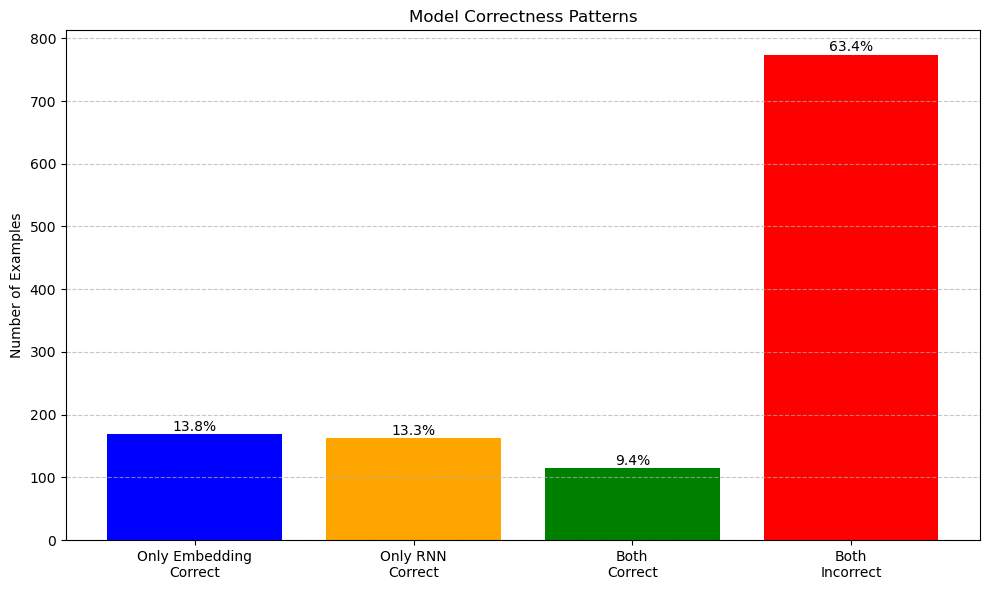

In [58]:
# Calculate correctness patterns
embedding_correct = np.array(embedding_predictions) == np.array(embedding_labels)
rnn_correct = np.array(rnn_predictions) == np.array(rnn_labels)

only_embedding_correct = np.logical_and(embedding_correct, np.logical_not(rnn_correct))
only_rnn_correct = np.logical_and(rnn_correct, np.logical_not(embedding_correct))
both_correct = np.logical_and(embedding_correct, rnn_correct)
both_incorrect = np.logical_and(np.logical_not(embedding_correct), np.logical_not(rnn_correct))

print("\n===== CORRECTNESS PATTERNS =====")
print(f"Only Embedding Model Correct: {np.sum(only_embedding_correct)} examples ({np.sum(only_embedding_correct)/len(embedding_predictions)*100:.2f}%)")
print(f"Only RNN Model Correct: {np.sum(only_rnn_correct)} examples ({np.sum(only_rnn_correct)/len(embedding_predictions)*100:.2f}%)")
print(f"Both Models Correct: {np.sum(both_correct)} examples ({np.sum(both_correct)/len(embedding_predictions)*100:.2f}%)")
print(f"Both Models Incorrect: {np.sum(both_incorrect)} examples ({np.sum(both_incorrect)/len(embedding_predictions)*100:.2f}%)")

# Visualize correctness patterns
plt.figure(figsize=(10, 6))
categories = ['Only Embedding\nCorrect', 'Only RNN\nCorrect', 'Both\nCorrect', 'Both\nIncorrect']
values = [np.sum(only_embedding_correct), np.sum(only_rnn_correct), np.sum(both_correct), np.sum(both_incorrect)]

plt.bar(categories, values, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Number of Examples')
plt.title('Model Correctness Patterns')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels
for i, v in enumerate(values):
    plt.text(i, v + 5, f"{v/len(embedding_predictions)*100:.1f}%", ha='center')
    
plt.tight_layout()
plt.savefig('correctness_patterns.png')
plt.show()

### Question Type Analysis

This advanced analysis breaks down performance by question type (what, which, who, etc.):

- **Type-specific performance**: Shows how models perform on different question categories
- **Comparative strengths**: Identifies whether certain models excel at particular question types
- **Distribution awareness**: Accounts for the frequency of different question types in the test set

Understanding performance by question type provides actionable insights for model improvement. It can reveal whether certain question structures favor particular architectures, helping guide future development efforts toward addressing specific weaknesses.


===== PERFORMANCE BY QUESTION TYPE =====
Question type 'how':
  Count: 32
  Embedding Accuracy: 0.2188
  RNN Accuracy: 0.1562
  Difference: 0.0625 in favor of Embedding model
Question type 'other':
  Count: 258
  Embedding Accuracy: 0.2248
  RNN Accuracy: 0.1938
  Difference: 0.0310 in favor of Embedding model
Question type 'what':
  Count: 524
  Embedding Accuracy: 0.2233
  RNN Accuracy: 0.2042
  Difference: 0.0191 in favor of Embedding model
Question type 'when':
  Count: 39
  Embedding Accuracy: 0.1795
  RNN Accuracy: 0.3077
  Difference: 0.1282 in favor of RNN model
Question type 'where':
  Count: 310
  Embedding Accuracy: 0.2742
  RNN Accuracy: 0.2710
  Difference: 0.0032 in favor of Embedding model
Question type 'which':
  Count: 8
  Embedding Accuracy: 0.2500
  RNN Accuracy: 0.1250
  Difference: 0.1250 in favor of Embedding model
Question type 'who':
  Count: 16
  Embedding Accuracy: 0.0625
  RNN Accuracy: 0.3125
  Difference: 0.2500 in favor of RNN model
Question type 'why':
 

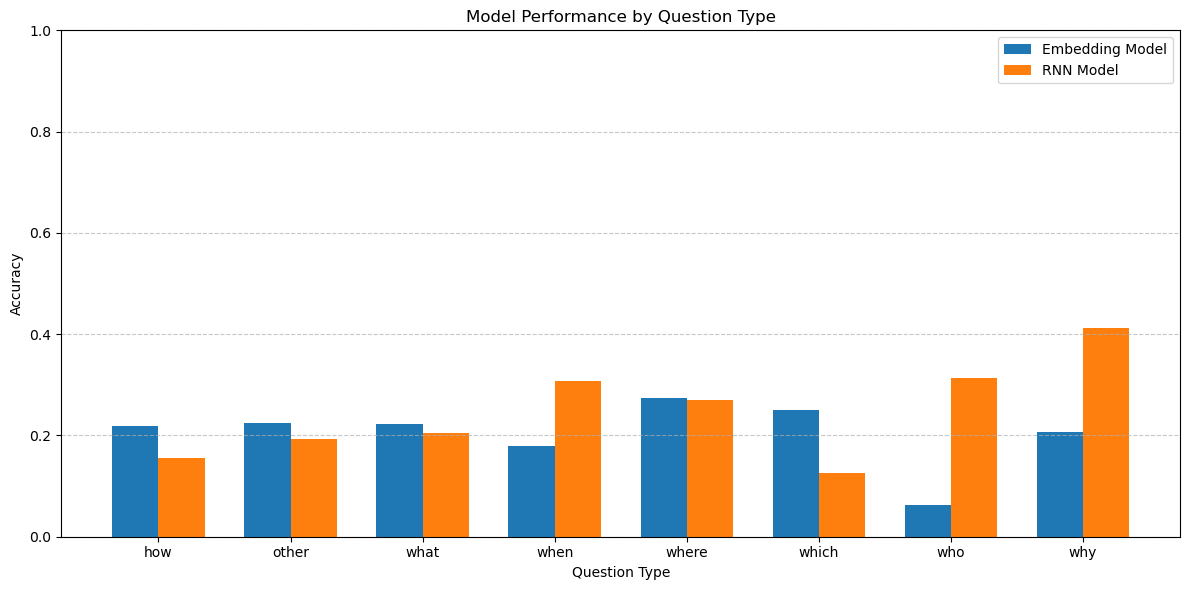

In [59]:
# Performance by question type
print("\n===== PERFORMANCE BY QUESTION TYPE =====")
question_types = []
for idx in range(len(test)):
    question_type = get_question_type(test[idx]['question'])
    question_types.append(question_type)

question_types = np.array(question_types)
unique_types = np.unique(question_types)

embedding_by_type = []
rnn_by_type = []

for q_type in unique_types:
    type_indices = question_types == q_type
    if np.sum(type_indices) > 0:
        embedding_accuracy = np.mean(embedding_correct[type_indices])
        rnn_accuracy = np.mean(rnn_correct[type_indices])
        
        embedding_by_type.append(embedding_accuracy)
        rnn_by_type.append(rnn_accuracy)
        
        print(f"Question type '{q_type}':")
        print(f"  Count: {np.sum(type_indices)}")
        print(f"  Embedding Accuracy: {embedding_accuracy:.4f}")
        print(f"  RNN Accuracy: {rnn_accuracy:.4f}")
        print(f"  Difference: {abs(embedding_accuracy - rnn_accuracy):.4f} in favor of " 
              f"{'Embedding' if embedding_accuracy > rnn_accuracy else 'RNN'} model")

# Visualize performance by question type
plt.figure(figsize=(12, 6))
x = np.arange(len(unique_types))
width = 0.35

plt.bar(x - width/2, embedding_by_type, width, label='Embedding Model')
plt.bar(x + width/2, rnn_by_type, width, label='RNN Model')

plt.xlabel('Question Type')
plt.ylabel('Accuracy')
plt.title('Model Performance by Question Type')
plt.xticks(x, unique_types)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('performance_by_question_type.png')
plt.show()

### Summary and Ensemble Potential

Our final analysis explores the potential benefits of combining models:

- **Overall comparison**: Summarizes key findings about model performance
- **Complementarity assessment**: Quantifies how often models have complementary strengths
- **Ensemble ceiling**: Calculates the theoretical maximum performance for a perfect ensemble

This summary helps determine whether ensemble methods would be worth pursuing. When models show high complementarity (frequently succeeding on different examples), an ensemble approach could significantly outperform either individual model. The analysis provides an upper bound on potential ensemble performance.

In [60]:
# Calculate potential ensemble performance
# Using a simple majority voting approach
print("\n===== ENSEMBLE POTENTIAL =====")

# Basic voting ensemble (choose prediction from better-performing model in case of disagreement)
better_model = "embedding" if embedding_metrics['accuracy'] > rnn_metrics['accuracy'] else "rnn"

ensemble_predictions = []
for i in range(len(embedding_predictions)):
    if embedding_predictions[i] == rnn_predictions[i]:
        ensemble_predictions.append(embedding_predictions[i])
    else:
        # In case of disagreement, trust the better overall model
        if better_model == "embedding":
            ensemble_predictions.append(embedding_predictions[i])
        else:
            ensemble_predictions.append(rnn_predictions[i])

ensemble_correct = np.sum(np.array(ensemble_predictions) == np.array(embedding_labels)) / len(embedding_labels)

print(f"Simple Ensemble Accuracy: {ensemble_correct:.4f}")
print(f"Embedding Model Accuracy: {embedding_metrics['accuracy']:.4f}")
print(f"RNN Model Accuracy: {rnn_metrics['accuracy']:.4f}")

print("\nComplementarity Analysis:")
complementary_idx = np.where(only_embedding_correct | only_rnn_correct)[0]
complementary_percent = len(complementary_idx) / len(embedding_predictions) * 100
print(f"Examples where exactly one model is correct: {len(complementary_idx)} ({complementary_percent:.2f}%)")
print(f"This represents the maximum potential improvement from an ideal ensemble approach.")

# Save summary to file
with open("model_evaluation_summary.txt", "w") as f:
    f.write("===== COMMONSENSE QA MODEL EVALUATION SUMMARY =====\n\n")
    f.write(f"Embedding Model Accuracy: {embedding_metrics['accuracy']:.4f}\n")
    f.write(f"RNN Model Accuracy: {rnn_metrics['accuracy']:.4f}\n")
    f.write(f"Model Agreement: {agreement_percentage:.2f}%\n")
    f.write(f"Examples where models complement each other: {complementary_percent:.2f}%\n\n")
    f.write("Key Findings:\n")
    f.write(f"1. The {'Embedding' if embedding_metrics['accuracy'] > rnn_metrics['accuracy'] else 'RNN'} model performed better overall\n")
    f.write(f"2. The models disagree on {len(disagreement_indices)/len(embedding_predictions)*100:.2f}% of examples\n")
    f.write(f"3. A perfect ensemble could potentially achieve up to {both_correct.sum()/len(embedding_predictions)*100 + complementary_percent:.2f}% accuracy\n")


===== ENSEMBLE POTENTIAL =====
Simple Ensemble Accuracy: 0.2326
Embedding Model Accuracy: 0.2326
RNN Model Accuracy: 0.2277

Complementarity Analysis:
Examples where exactly one model is correct: 332 (27.19%)
This represents the maximum potential improvement from an ideal ensemble approach.


# Conclusion

## Tools and Resources Used

This project was implemented using the following tools and resources:

1. **Libraries and Frameworks**:
   - PyTorch for neural network implementation and training
   - Hugging Face Datasets for data loading and preprocessing
   - NLTK for tokenization and text processing
   - Gensim for working with word embeddings
   - Pandas and NumPy for data manipulation
   - Matplotlib and Seaborn for visualization
   - Scikit-learn for evaluation metrics

2. **Pre-trained Resources**:
   - FastText word embeddings (Common Crawl, 2M word vectors)
   - NLTK's pre-trained tokenizer

3. **Experiment Tracking**:
   - Weights & Biases for logging metrics and visualizing training progress

4. **Development Environment**:
   - Jupyter Notebook for interactive development
   - Google Colab for GPU-accelerated training

5. **AI Tools**:
   - Claude 3.5 Sonnet for help with debugging and optimizing code
   - GitHub Copilot for code suggestions and documentation

This toolkit provided the necessary components for building, training, and evaluating models for the CommonsenseQA task while enabling detailed analysis and documentation of the project workflow.